<font color='blue'> En esta práctica se pretenden abordar algunos elementos básicos relativos al aprendizaje profundo utilizando Keras (https://keras.io/). Para ello, se emplean dos tareas del ámbito del procesado de imágenes y visión por computador: clasificación de imágenes (_image classification_) y eliminación de ruido en imágenes (_image denoising_). Para tener un conocimiento más profundo de algunas de estas tareas y métodos, así como familiarizarse con modelos más avanzados, se emplaza al estudiantado a cursar Visión por Computador (asignatura de 4º curso).

# <font color='blue'>Ejercicio 1: PROBLEMA DE CLASIFICACIÓN DE IMÁGENES USANDO REDES CONVOLUCIONALES PROFUNDAS Y COMPARACIÓN CON TÉCNICAS CLÁSICAS DE APRENDIZAJE AUTOMÁTICO (7 puntos) </font>

<font color='blue'> En este ejercicio los alumnos se enfrentarán a un problema de clasificación de imágenes. Más concretamente, se enfrentarán al problema de clasificación de imágenes denominado $\textit{MNIST}$ (https://en.wikipedia.org/wiki/MNIST_database), que incluye dígitos manuscritos. Como consecuencia, este conjunto de datos contiene información sobre 10 clases de imágenes (dígitos del $0$ al $9$).

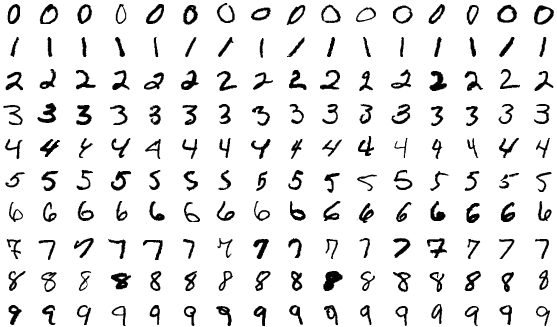



<font color='blue'> Este ejercicio consta de tres apartados:


1.   Implementación y experimentación con una red convolucional sencilla inspirada en LeNet5.
2.   Implementación y experimentación con características HOG y SVMs. Comparación de los resultados proporcionados por esta aproximación clásica con los proporcionados por aprendizaje profundo.
3.   Implementación y experimentación con el modelo profundo que quieran implementar o emplear los estudiantes.



## <font color='blue'> Apartado 1. Implementación y experimentación con una red convolucional sencilla inspirada en LeNet5 (3 puntos)

<font color='blue'> [LeNet5](https://en.wikipedia.org/wiki/LeNet) fue una de las primeras redes convolucionales, y se empleó exitosamente ya en los años 90 en la clasificación de dígitos manuscritos. Véase, por ejemplo, _LeCun et al. (1998). Gradient based learning applied to document recognition. Proceedings of the IEEE. 86(11): 2278-2324_.

<font color='blue'> En este ejercicio emplearemos una versión ligeramente modificada de la misma, que consta de las siguientes capas:

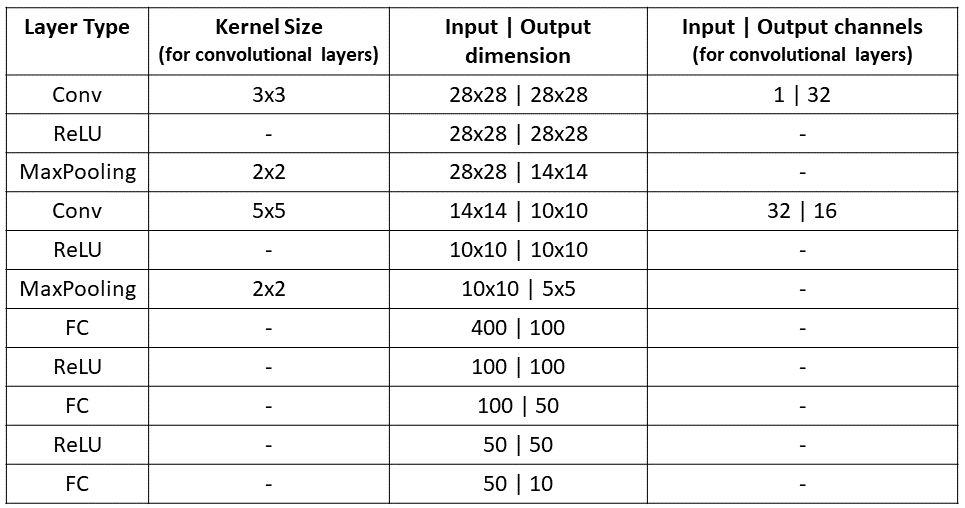

<font color='blue'> A continuación, el alumnado debe implementar en Keras esta arquitectura, y entrenarla y validarla con el conjunto de datos MNIST (ya disponible entre los conjuntos de datos por defecto en Keras: https://keras.io/api/datasets/). A la hora de entrenar modelos profundos es importante acordarse de configurar el cuaderno de modo que se ejecute en GPU (`Editar - Configuración del Cuaderno - Acelerador por Hardware`). De lo contrario, los entrenamientos serán innecesariamente lentos.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

# Establecer la semilla que vamos a utilizar
np.random.seed(42)

from tensorflow import keras

#import keras
!pip install np_utils
from keras.utils import to_categorical
from keras.datasets import mnist
keras.utils.set_random_seed(42)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

# NÚMERO DE CLASES
num_classes = 10


# DIMENSIONES DE ENTRADA DE LAS IMAGENES
img_rows, img_cols = 28, 28

# CARGAMOS LOS DATOS DE ENTRENAMIENTO Y TEST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# FORMATEAMOS Y NORMALIZAMOS LOS DATOS
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Transformamos los vectores de clases en matrices.
# Cada componente se convierte en un vector de ceros
# con un uno en la componente correspondiente a la
# clase a la que pertenece la imagen. Este paso es
# necesario para la clasificación multiclase en keras.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


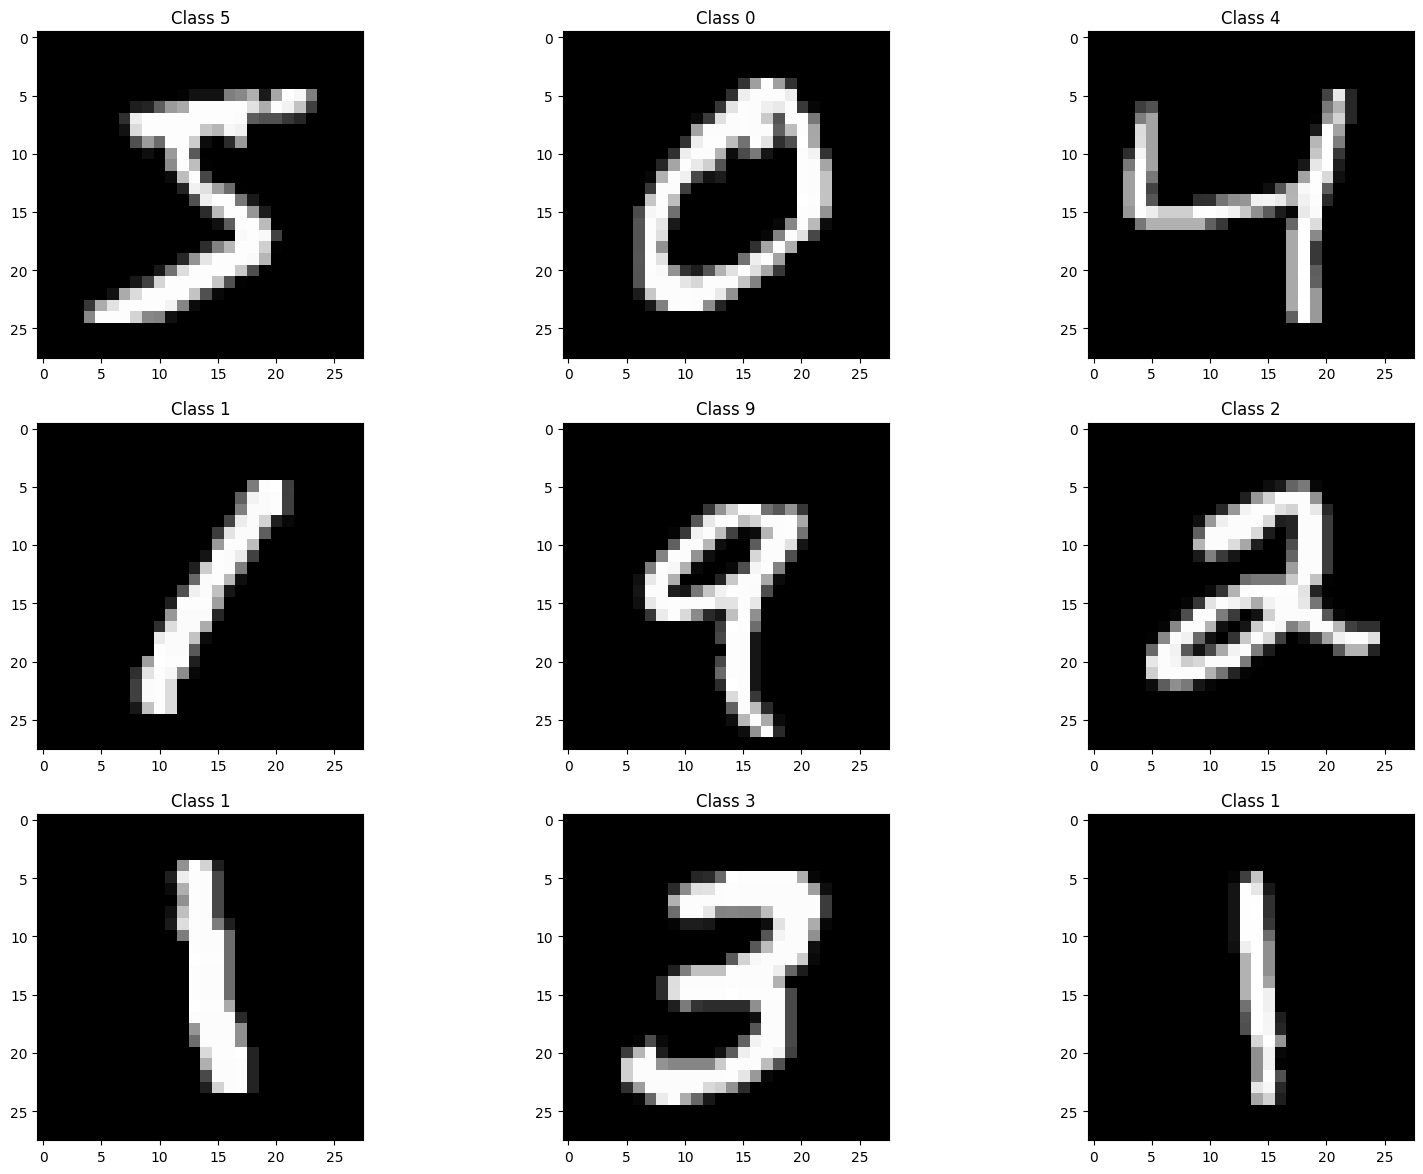

In [ ]:
#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)

plt.show()

<font color='blue'> El alumnado debe escoger empíricamente el tamaño de _batch_, el número de épocas y el _learning rate_. Se debe documentar en detalle todo el proceso de entrenamiento y selección de hiperparámetros (incluyendo qué metricas y función de pérdida se emplean y por qué). Se debe emplear _early stopping_ (https://keras.io/api/callbacks/early_stopping/), y los alumnos deben explicar en qué consiste este proceso de regularización. Se puede emplear tanto _hold-out_ como _cross-validation_ como protocolo de validación experimental pero, en cualquier caso, se deben explicar y justificar adecuadamente todas las decisiones tomadas. Se debe dejar un $20\%$ de los datos de entrenamiento para validación. Finalmente, se debe comparar el rendimiento obtenido con dos optimizadores: AdamW y Adadelta.

<font color='blue'> Resulta fundamental realizar un _.summary()_ del modelo creado y demostrar que se comprenden los distintos elementos que allí aparecen: nombre/tipo de capa, dimensiones de salida, y número de parámetros de la red.

In [ ]:
# Esta función pinta dos gráficas, una con la evolución
# de la función de pérdida en el conjunto de train y
# en el de validación, y otra con la evolución de la
# accuracy en el conjunto de train y el de validación.
# Es necesario pasarle como parámetro el historial del
# entrenamiento del modelo (lo que devuelve la
# función fit()).
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()


In [ ]:
# Esta función devuelve la accuracy de un modelo,
# definida como el porcentaje de etiquetas bien predichas
# frente al total de etiquetas. Como parámetros es
# necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de
# keras (matrices donde cada etiqueta ocupa una fila,
# con un 1 en la posición de la clase a la que pertenece y un 0 en las demás).
def calcularAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmax(preds, axis = 1)
    accuracy = sum(labels == preds)/len(labels)
    return accuracy


####**Introducción a deep learning**

Empezamos a enfrentarnos a nuestro primer problema de **deep learning** en la asignatura. Vamos a tratar de construir una ***red neuronal convolucional*** muy parecida a **LeNet5**, nombre que hace honor a *Yann LeCun*. Vamos a trabajar sobre uno de los datasets más conocidos de clasificación multiclase MNIST y para ello vamos a usar los conceptos vistos en clase de redes neuronales, todos ellos explicados ahora a continuación junto al código de la práctica.

Merece hacer una breve síntesis de cómo trabajan las redes neuronales en general (no las convolucionales y explicar a continuación cómo se van a comportar en nuestro caso):

Tal y como se ha visto en clase, las redes neuronales cuentan con:

  1. **Neuronas**: Son las que reciben las entradas, las procesan haciendo una suma ponderada de los pesos (asignando una *importancia*) y después aplican una función de activación que va a modificar la salida.
  2. **Capas**: Son las que definimos explícitamente cuando las programamos y determinan el funcionamiento interno de la red.
  3. **Conexiones**: Son los pesos por los que se van a ir multiplicando las entradas de las neuronas y vamos a ir entrenando.

Las redes neuronales son capaces de, a través de las capas, ir aprendiendo características **de más bajo a más alto nivel**.

Pues bien, el principal problema de las redes neuronales es su complejidad pues cada conexión representa un peso a entrenar, y como ya sabemos, cuantos más pesos tengamos que entrenar más costoso nos resultará. La idea general por la que surgen las **redes convolucionales** es esta idea, pues se pretende cubrir problemas en los que los datos se presentan en forma de matriz y se ha de tratar con muchos pesos.

Para ello se hace uso de la **CONVOLUCIÓN**:

In [ ]:
##Funcionamiento y convergencia de K-Means en 2D
from IPython.display import Image
Image(url='https://coolgpu.github.io/coolgpu_blog/assets/images/Conv2d_0p_1s_1inCh.gif')

La **convolución** es una operación en la que a partir de un **filtro o kernel** se reduce la dimensionalidad de la entrada, sin perder necesariamente información. Se utiliza para extraer características de las imágenes, como bordes, texturas y patrones. De esta manera, el número de pesos a entrenar se reduce drásticamente y lo que se pretende haciendo convoluciones es de lo que hablabamos de las redes neuronales, **aprender cada vez características de más alto nivel**.

En una red convolucional se elige el número de filtros que se quiere usar, así como la dimensión de dicho filtro, cómo se desplaza (*strides*) y si se quiere conservar la dimensionalidad (*padding*).

\\
De esta manera, se consigue que **el número de operaciones sea mucho menor** (*Conectividad dispera*) y que el **número de parámetros a aprender también se reduzca** (*weight sharing*).

####**Explicación capa a capa**

Pues bien, una **red convolucional o ConvNet** es una red neuronal que, al menos, posee una capa convolucional. Veamos a continuación, capa a capa, la red que se nos pide diseñar:

1. **Capa de input**: Simplemente en *keras* se trata como una capa más y se le pasan la dimensión de las imágenes de entrada.
2. **Capa de convolución**: *Conv2D* en *keras*. Dimensión de profundidad de 1 de entrada (sólo tienen un canal las imágenes de entrada) y dimensión 32 para la salida. Es decir, aplicamos $32$ filtros o *kernels* de tamaño 3x3, con *stride* 1 (vamos celda a celda) y padding = 'same' que indica que queremos que la imagen mantenga la dimensión inicial. Como función de activación usaremos ReLU o unidad lineal rectificada:

 - Esta función presenta **no linealidad para valores mayores que 0**, de manera que la red se puede ajustar así a problemas más complejos que no se reduzcan a un problema lineal. Una de las ventajas que tiene esta función es que ReLU produce salidas escasas. Esto significa que, en promedio, solo una parte de las neuronas estarán activas en cualquier momento dado, lo cual puede ayudar a reducir el riesgo de sobreajuste.

 <center><img src='https://miro.medium.com/max/4362/1*TbZnkZYI5vwOQGUBd6uXAQ.png' width="700" height="400"></center>

 Imagen extraída de https://towardsdatascience.com/activation-functions-in-neural-networks-83ff7f46a6bd

    - **Número de pesos en la capa**: $3$x$3$x$1$+$1$ por filtro $\implies 10$ x $32 filtros$. En total **320**. (Más abajo podemos comprobar que estamos haciendo bien los cálculos)

\\
2. **Capa de maxPooling**: Reduce dimensionalidad para añadir invarianza a pequeñas traslaciones de la entrada (los números del dataset pueden aparecer rotados y trasladados ligeramente en cada instancia). lo hacemos con tamaño $2$x$2$.

 <center><img src='https://th.bing.com/th/id/R.81a0fa489ea440d54e72513f5a4c0b35?rik=JOf4RGdDTdVkNA&pid=ImgRaw&r=0&sres=1&sresct=1' width="600" height="300"></center>

 Imagen extraída de https://computersciencewiki.org/index.php/Max-pooling_/_Pooling

 En esta capa no se añaden pesos, pero sí que cambia la **dimensión de la imagen a la mitad**.

 \\
3. **Capa de convolución**: Ahora usamos 16 filtros de tamaño $5$x$5$. Ahora no hacemos padding, por lo que la imagen pierde 4 de dimensión, es decir, ahora tendremos imágenes de $10$x$10$.

  - **Número de pesos en la capa**: $5$x$5$x$32$+$1$ por filtro $\implies 801$ x $16 filtros$. En total **12816**.

\\
4. **Capa de maxPooling**: De nuevo hacemos *maxpooling* con tamaño $2$x$2$ reduciendo a la mitad la dimensión. La imagen tendrá ahora dimensión 5.

\\
5. **Capa *Fully-Connected***: Se conectan todas y cada una de las neuronas de la capa anterior con todas y cada una de las neuronas de la siguiente. Después de las capas convolucionales y de pooling en una CNN, las capas totalmente conectadas se utilizan para combinar las características extraídas y **aprender interacciones complejas** entre ellas. Estas capas permiten que la red aprenda combinaciones de características de alto nivel que son útiles para la clasificación. Se hace la conexión con 100 neuronas nuevas. De nuevo se le añade como función de activación a cada neurona *ReLU*.

  - **Número de pesos en la capa**: $400 + 1$x$100$. En total **40100**.

**Para conectar todas las neuronas se debe hacer un *flattening* previo, es decir, convertir todos los pesos a un vector unidimensional para que todas las neuronas puedan conectarse entre ellas. Esto nos deja $5$x$5$x$16$ neuronas, $400$.**

\\
6. **Capa *Fully-Connected***: Misma operación ahora para 50 neuronas. Se vuelve a usar la misma función de activación.
  - **Número de pesos en la capa**: $100 + 1$x$50$. En total **5050**.

7. **Capa *Fully-Connected***: Misma operación ahora para 10 neuronas, correspondientes ahora a la salida, es decir los 10 números de nuestro dataset. La principal diferencia ahora es la función de activación. En los problemas de clasificación multiclase se va a usar la función ***softmax***. Cuando se usa softmax en la capa de salida junto con la función de pérdida de entropía cruzada (***cross-entropy loss***, explicada más tarde), se obtiene una combinación efectiva que penaliza las predicciones incorrectas de manera adecuada y facilita el aprendizaje. De hecho, normaliza la salida para que cada predicción corresponda a la probabilidad de que la entrada pertenezca a dicha clase.

<center><img src='https://ambrapaliaidata.blob.core.windows.net/ai-storage/articles/1_hbrZSUS.png'></center>

Imagen extraída de https://insideaiml.com/blog/SoftMaxActivation-Function-1034
  - **Número de pesos en la capa**: $50 + 1$x$10$. En total **510**.




####**Definición primera red**

In [ ]:
#A CUBRIR POR EL ALUMNADO
from keras.layers import Input

def definirRed1():
  model = keras.Sequential()
  model.add(Input(shape = (28,28, 1)))
  model.add(Conv2D(32, (3,3), strides = 1 , padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(16, (5,5), strides = 1 , padding = 'valid', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Flatten())
  model.add(Dense(100, activation = 'relu'))
  model.add(Dense(50, activation = 'relu'))
  model.add(Dense(10, activation = 'softmax'))

  model.summary()

  return model

model = definirRed1()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 10, 10, 16)        12816     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 100)              

Haciendo *summary()* podemos ver como queda la red. Como habíamos anticipado, el número de pesos es correcto y tendremos un total de **58796** pesos entrenables.

Ahora con ayuda de la librería ***visualkeras*** vamos a visualizar cómo queda el modelo o red definido:

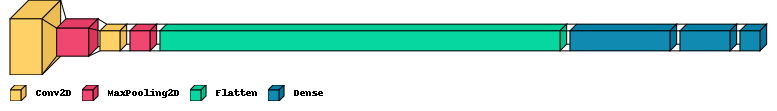

In [ ]:
#Descomentar si se quiere ejecutar
#!pip install visualkeras
import visualkeras

visualkeras.layered_view(model, legend = True, scale_xy=2, scale_z=1, max_z=1000)

Ver https://github.com/paulgavrikov/visualkeras

Realmente, se parece a *LeNet5* porque usa 5 capas (2 convolucionales y 3 *fully conected*).

Respecto a lo comentado en clase de prácticas sobre la partición hecha para validación, pues cabía la posibilidad de que si no estuviesen desordenadas las instancias por clases, entrenasemos con instancias del 1-8 y validasemos con el 9, por ejemplo, no hemos de preocuparnos pues el conjunto de etiquetas de MNIST está **desordenado**.

In [ ]:
#Aparentemente las etiquetas están desordenadas
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


####**Discusión de hiperparámetros**

Comentemos un poco en qué consiste ***EarlyStopping*** y por qué sirve como método de **regularización**. El objetivo principal de este método es detener el entrenamiento de un modelo **antes de que comience a sobreajustar** los datos de entrenamiento, es decir, cuando empieza a aprender los detalles específicos del conjunto de datos de entrenamiento en lugar de generalizar bien en datos no vistos.

**¿Cómo funciona?**

1. Se realiza un **monitoreo** de una métrica de rendimiento (generalmente la pérdida o el error, aunque nosotros usaremos la **pérdida en validación o *val_loss***) tanto en el conjunto de entrenamiento como en un conjunto de validación.
2. Después de cada época, se compara la métrica de rendimiento del conjunto de validación con la mejor métrica de validación obtenida hasta ese momento.
3. Si la métrica de validación no mejora durante un número predeterminado de épocas consecutivas (llamadas **paciencia** o ***patience***), se detiene el entrenamiento.

El entrenamiento se detiene y se selecciona el modelo que tenga el mejor rendimiento en el conjunto de validación antes de que la métrica comenzara a empeorar. Tras varios experimentos encuentro que para **4 como paciencia**, el modelo entrena un buen número de épocas obteniendo una buena *accuracy*. Menos paciencia hace que termine antes y se obtienen peores resultados. Más paciencia permite al modelo continuar aunque pierda *accuracy*.

\\
Para el tema del **batch_size**, he encontrado cierta información sobre cómo escoger este hiperparámetro, que afecta muy considerablemente al tiempo de entrenamiento. Esto se debe a que valores más bajos de *batch* hacen que tengamos menos actualizaciones de pesos por época y por tanto necesitemos más épocas para llegar al mismo error. El paper citado a continuación establece que, por defecto **32 es un buen valor** y considero que como MNIST es un dataset que no es excesivamente grande va a trabajar bien con este tamaño de *batch*. También, generalmente, lotes o *batches* más pequeños producen un mejor error en *test*, es decir, realizan una generalización mejor. (Igualmente he hecho pruebas con distintos tamaños y da mejores resultados 32)

Se suelen usar potencias de 2 para el tamaño por temas de cómo trabajan las GPU's con las imágenes.

Véase lo comentado en https://arxiv.org/pdf/1206.5533

\\
Respecto al **learning rate**, también es un parámetro muy delicado y totalmente decisivo para el entrenamiento de nuestra red. Un *lr* más alta permite cambios más grandes en los pesos, pero puede hacer que el modelo converja de manera inestable o incluso que no converja en absoluto. Por otro lado, un *lr* más bajo puede hacer que el entrenamiento sea más estable, pero a expensas de la velocidad del mismo. También se puede usar un **learning schedule**, pues este nos permite más flexibilidad, y adaptabilidad para el learning rate. La idea es hacerlo cada vez más pequeño conforme nos acercamos al final del entrenamiento. (De nuevo, tras considerar varios experimentos, escojo como lr inicial 0.01)

Vamos a usar *ExponentialDecay* como *scheduler*, con un learning rate inicial de 0.01, un valor considerable. De esta manera los cambios a los pesos van a ser mucho mayores e igualmente el *learning rate* descenderá con el tiempo. El resto de parámetros son específicos de *ExponentialDecay* y voy a probar con los siguientes:

(**Me doy cuenta explicando los dos optimizadores más abajo de que realmente puede ser redundante usar un Scheduler mientras los optimizadores usados van calculando también su propio *Learning rate*. Igualmente, vamos a combinarlos, los resultados no deberían variar demasiado**)

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience = 5)

loss=keras.losses.CategoricalCrossentropy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

#Empezamos usando Adam
optimizer = tf.keras.optimizers.AdamW(learning_rate = lr_schedule)


model.compile(optimizer = optimizer, loss = loss, metrics=['accuracy'])
hist = model.fit(x_train, y_train, batch_size = 32, epochs = 50, verbose=1, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1500/1500 [==============================] - 9s 5ms/step - loss: 0.1725 - accuracy: 0.9490 - val_loss: 0.0797 - val_accuracy: 0.9793
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0966 - accuracy: 0.9747 - val_loss: 0.0850 - val_accuracy: 0.9798
Epoch 3/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0917 - accuracy: 0.9766 - val_loss: 0.0973 - val_accuracy: 0.9804
Epoch 4/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0794 - accuracy: 0.9803 - val_loss: 0.0935 - val_accuracy: 0.9773
Epoch 5/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0731 - accuracy: 0.9808 - val_loss: 0.0771 - val_accuracy: 0.9828
Epoch 6/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0701 - accuracy: 0.9825 - val_loss: 0.0862 - val_accuracy: 0.9784
Epoch 7/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0599 - accuracy: 0.9842 - val_loss: 0.0702 - val_accuracy:

El uso de *early stopping* se puede ver bien reflejado en la evolución siguiente:

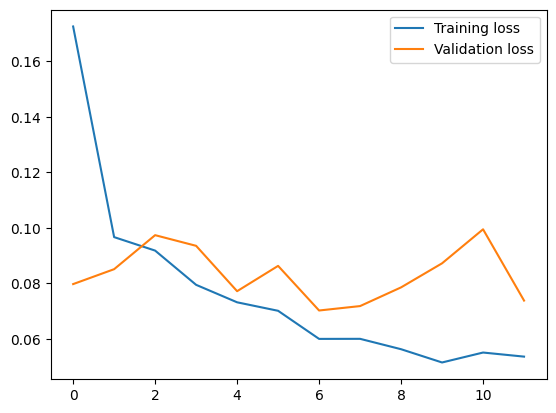

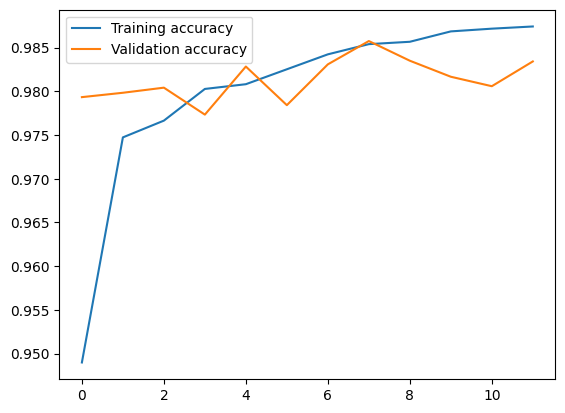

In [ ]:
mostrarEvolucion(hist)

In [ ]:
calcularAccuracy(y_train, model.predict(x_train))

1875/1875 [==============================] - 3s 2ms/step


0.9886666666666667

####**Optimizadores**

Observamos unas muy buenas métricas de entrenamiento, con un **98.86% de accuracy en *train* y un 98.34% en *validation***. Es interesante fijarse siempre en las gráficas de evolución pues nos dan mucha información de cómo se ha desarrollado el entrenamiento y podemos usarlas para verificar el buen funcionamiento de la red. Por ejemplo, vemos que es a partir de la época número 11 que dejamos de obtener un mejor valor para *validation* que para *train* y por eso a las 5 épocas (*patience*) deja de entrenar, acción de ***EarlyStopping***.

Hemos usado primeramente **AdamW**, y ahora a continuación usaremos **AdaDelta**.

* **AdamW**: Es un método de *Descenso de Gradiente Estocástico* y es una variante del optimizador *Adam*. Este método agrega un término de **decadencia** (corrección) de peso de manera más adecuada. En Adam tradicional, el término de regularización $L2$ se añade a la actualización del gradiente, lo cual puede causar problemas ya que combina la regularización con la adaptación del gradiente que se va calculando. AdamW separa explícitamente la regularización de la actualización del gradiente, lo cual mejora la estabilidad y el rendimiento del algoritmo. Esta separación de los términos de regularización ayuda a evitar problemas de sobreajuste y permite una **convergencia más estable y rápida**.

Véase 'Decoupled Weight Decay Regularization' by Loshchilov, Hutter et al., 2019. (https://arxiv.org/pdf/1711.05101)

\\
* **Adadelta**: Para entender AdaDelta, es útil comprender primero *AdaGrad*. *AdaGrad* ajusta la tasa de aprendizaje o *learning rate* para cada parámetro en función de las proporciones de los gradientes calculados. Un problema con AdaGrad es que el *lr* puede disminuir demasiado con el tiempo, lo que puede hacer que el algoritmo deje de aprender muy rápido.

  AdaDelta, en cambio, adapta la tasa de aprendizaje sin necesidad de una tasa de aprendizaje inicial, y lo hace utilizando una media de los gradientes en lugar de la suma acumulativa. Esto provoca que el *learning rate* no disminuya indefinidamente, lo que permite una optimización continua $\implies$ tiempos más grandes pues casi siempre agotará las épocas.

Veámos ahora el comportamiento para la misma red pero ahora usando **Adadelta**:

####**Definición segunda red**

In [ ]:
#Definimos otra red porque Keras guarda los pesos
model2 = definirRed1()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 16)        12816     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 100)              

In [ ]:
#Ahora vamos a probar AdaDelta
optimizer = tf.keras.optimizers.Adadelta(learning_rate = lr_schedule)

model2.compile(optimizer = optimizer, loss = loss, metrics=['accuracy'])
hist2 = model2.fit(x_train, y_train, batch_size = 32, epochs = 50, verbose=1, validation_split=0.2, callbacks=[callback])

Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 1.9666 - accuracy: 0.3960 - val_loss: 1.2995 - val_accuracy: 0.6853
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.8566 - accuracy: 0.7673 - val_loss: 0.5783 - val_accuracy: 0.8357
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5283 - accuracy: 0.8457 - val_loss: 0.4234 - val_accuracy: 0.8802
Epoch 4/50
1500/1500 [==============================] - 8s 5ms/step - loss: 0.4177 - accuracy: 0.8775 - val_loss: 0.3500 - val_accuracy: 0.8997
Epoch 5/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3547 - accuracy: 0.8961 - val_loss: 0.3023 - val_accuracy: 0.9144
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3141 - accuracy: 0.9073 - val_loss: 0.2718 - val_accuracy: 0.9232
Epoch 7/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2849 - accuracy: 0.9149 - val_loss: 0.2494 - val_accuracy:

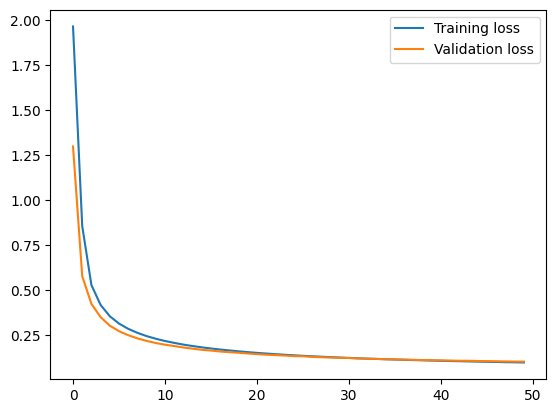

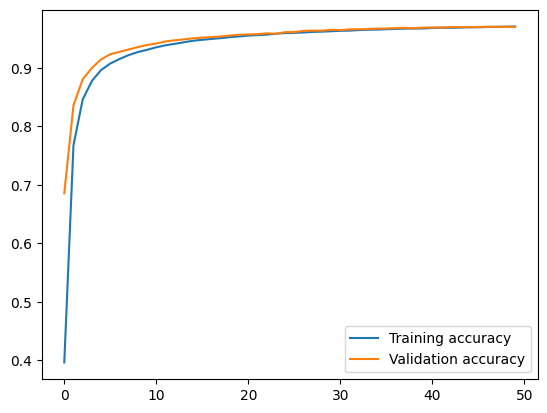

In [ ]:
mostrarEvolucion(hist2)

In [ ]:
calcularAccuracy(y_train, model2.predict(x_train))

1875/1875 [==============================] - 3s 2ms/step


0.9704333333333334

Vemos que los resultados usando ahora *Adadelta* son ligeramente peores y nos dan peor accuracy tanto en ***train* como en validación: 97.1% y 97.06%**, respectivamente. Sin embargo, hacemos énfasis en lo explicado:

  El entrenamiento que hace AdaDelta es mucho más **suave y gradual** que el que hace AdamW, que es **más abrupto y con mucho más cambio**. Esto se ve con un vistazo a las gráficas de evolución proporcionadas. Para problemas donde busquemos más estabilidad usaremos AdaDelta antes que AdamW. Sin embargo, debido a los resultados obtenidos, así como la gran rapidez de AdamW nos vamos a quedar con esta red.

(Destacar que no sacamos el valor en test para la red que usa AdamW, pues lo hago en el siguiente apartado, donde también comparamos estas dos redes con una técnica más clásica de Machine Learning)

## <font color='blue'> Apartado 2. Implementación y experimentación con técnicas clásicas (características HOG y SVMs) (2 puntos)

<font color='blue'> Ahora vamos a emplear SVM y características de HOG para clasificar estas imágenes. Se debe describir todo el proceso de ajuste realizado, incluyendo la selección de hiperparámetros, y se deben discutir las ventajas y desventajas de esta aproximación en comparación con el uso de _deep learning_, así como los resultados obtenidos y la calidad de las características empleadas.

In [ ]:
from skimage.feature import hog

fd = hog(x_train[0], orientations=4, pixels_per_cell=(10,10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

x_train_HOG = np.zeros((x_train.shape[0],len(fd)), np.float32)
x_test_HOG = np.zeros((x_test.shape[0],len(fd)), np.float32)

for i in range(x_train.shape[0]):
  x_train_HOG[i] = hog(x_train[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
for i in range(x_test.shape[0]):
  x_test_HOG[i] = hog(x_test[i], orientations=4, pixels_per_cell=(10, 10), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

In [ ]:
print(x_train_HOG.shape)

(60000, 16)


####**Explicación HOG**

Veamos qué valores toman estas características capturadas mediante HOG y expliquemos por encima cómo funciona este método de ***feature extraction***:

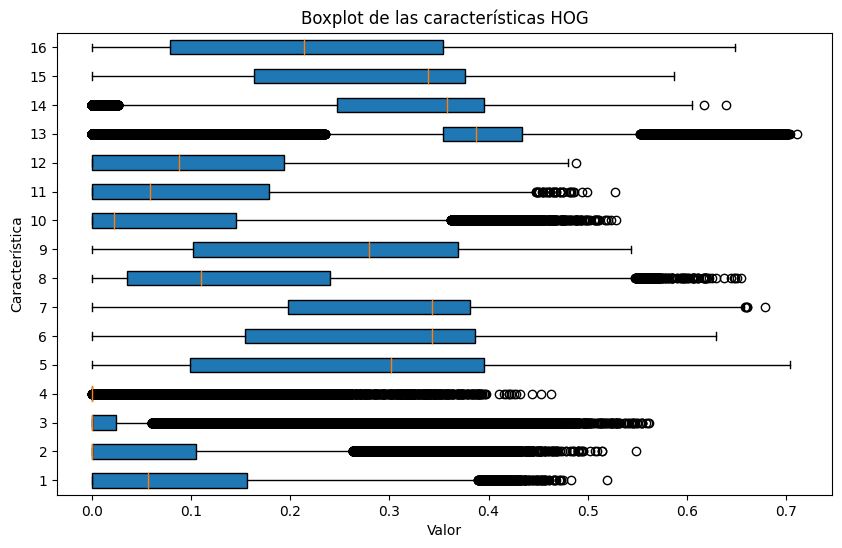

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(x_train_HOG[:, :16], vert=False, patch_artist=True)
plt.title('Boxplot de las características HOG')
plt.xlabel('Valor')
plt.ylabel('Característica')
plt.show()

In [ ]:
#Necesitamos y_train de nuevo, pues en el apartado anterior lo modificábamos a formato keras
#En este apartado usaremos, como en prácticas anteriores scikit-learn para abordar el problema
# desde el punto de vista del Machine Learning más clásico (no deep)
y_test2 = y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

El **HOG o Histograma de Gradientes Orientados** es una técnica de extracción de características (*feature extraction*) que captura la información de gradientes (bordes) en diferentes orientaciones dentro de una imagen. Esta técnica es particularmente útil para capturar formas y contornos, que son importantes para la clasificación de dígitos escritos a mano en el conjunto de datos MNIST.

Siguiendo la máxima de que ***pasar de un espacio multidimensional a uno unidimensional conlleva una inevitable pérdida de información***, no por ello las características que se extraen usando métodos como HOG tienen por qué ser de mala calidad. Veámos en qué aspectos HOG es bueno y en cuales no tanto:
 1. HOG ofrece cierta **robustez** frente a pequeñas transformaciones, como rotaciones y traslaciones menores. Esto es útil en MNIST, donde los dígitos pueden no estar perfectamente alineados.
 2. La calidad de las características HOG depende de la **elección de parámetros**, como el tamaño de las celdas, el tamaño de los bloques, y la cantidad de bins en los histogramas. Estos parámetros nos determinan la calidad de las características.
 3. Aunque HOG es robusto frente a pequeñas variaciones, puede **no manejar bien transformaciones más significativas**, como grandes rotaciones o deformaciones. Esto puede afectar la precisión en algunos casos donde los dígitos no están bien centrados o son muy variados.

<center><img src = 'https://www.researchgate.net/publication/337685532/figure/fig2/AS:831830496403457@1575335253692/The-processing-of-HOG-feature-extraction-A-Original-3D-face-image-B-input-3D-face.ppm' width="700" height="500"></center>

Imagen extraída de https://www.researchgate.net/figure/The-processing-of-HOG-feature-extraction-A-Original-3D-face-image-B-input-3D-face_fig2_337685532

Ver https://datasmarts.net/es/como-extraer-features-de-una-imagen-con-hog-en-scikit-image/

Lo que obtenemos aplicando HOG a las imágenes son instancias de dichas imágenes que ahora tienen 16 características. De esta manera, ahora podemos abordar el problema como uno clásico de **Machine Learning** (en lugar de Deep), empleando métodos usados en las prácticas anteriores, en este caso SVM.

 Como se nos presentó en las diapositivas de la práctica, la principal diferencia entre este enfoque y el de aprendizaje profundo realmente es el proceso de **Feature Extraction**, que en el apartado anterior no tuvimos que hacerlo. Esta es la primera **desventaja** que encontramos en este enfoque.

\\
####**Modelo SVM**

 Usaremos *scikit-learn* para el entrenamiento del SVM classifier. Una de las **ventajas** que presenta este enfoque es la complejidad computacional, pues, en general, *deep learning* emplea mucho más tiempo de entrenamiento pues es un proceso mucho más complejo. Esto nos permite hacer una breve búsqueda entre los posibles hiperparámetros del modelo (compensando ese tiempo). Haremos uso de *grid_search* ya empleado en prácticas anteriores, con objeto de encontrar los mejores valores para el modelo. Para ello, vamos a discutir primero los hiperparámetros con los que cuenta:
  - **C - regularización**: Inversamente proporcional a la *fuerza* de regularización que se quiere emplear.

  $$C \sum_{i=1, n} \mathcal{L} (f(x_i), y_i) + \Omega (w)$$

  Donde:
    - $\mathcal{L}$ es la función de pérdida
    - $\Omega$ es la función de penalización
    - $C$ controla la cantidad de regularización que se introduce

Ver https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html#sphx-glr-auto-examples-svm-plot-svm-scale-c-py

  Un valor pequeño de C implica una regularización más fuerte, lo que significa que el modelo dará más importancia a maximizar el margen incluso si eso resulta en un mayor error en el conjunto de entrenamiento. Esto puede ayudar a prevenir el sobreajuste.

  - **Kernel**: Define la función de transformación utilizada para convertir datos no lineales en un espacio de mayor dimensión donde sean más fácilmente separables. Algunos de estas funciones son:
    - **rbf (o kernel gaussiano)**: Es el más comunmente usado cuando los datos no tienen relaciones lineales.
    - **linear o lineal**: Es el más eficiente y útil cuando nuestros datos sabemos que son linealmente separables.
    
\\
Como no sabemos exactamente la distribución de los datos vamos a probar con kernel *rbf*, algo común cuando no se tiene esta información. Vamos con la selección de los hiperparámetros.

Pero antes, como en el apartado anterior, trabajamos con el mismo dataset, y nuestro modo de entrenar era usando un 20% de los datos del conjunto de entrenamiento para **validación**, ahora vamos entonces a usar el mismo criterio de entrenamiento pues queremos comparar las dos técnicas, una más clásica y otra de *deep learning*. Separamos entonces nuestro conjunto de train en train/validation:

In [ ]:
from sklearn.model_selection import train_test_split

x_train_HOG, x_val_HOG, y_train, y_val = train_test_split(x_train_HOG, y_train, test_size=0.2, random_state=42)

print(x_train_HOG.shape)
print(x_val_HOG.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 16)
(12000, 16)
(48000,)
(12000,)


El 20% de 60000 es 12000, que es el tamaño que va a tener nuestro conjunto de validación. Ahora si podemos hacer un **grid_search** en nuestro conjunto de train:

In [ ]:
#Tarda 31m 15s

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

(x_train, y_train), (x_test, y_test) = mnist.load_data()

params = {
    'C': [0.8, 1.0, 1.2],
}

clf = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring = 'accuracy',
    cv=3,
    n_jobs=5,
    verbose=3
)

clf.fit(x_train_HOG, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=5, param_grid={'C': [0.8, 1.0, 1.2]},
             scoring='accuracy', verbose=3)

In [ ]:
print(clf.best_params_)

{'C': 1.2}


Obtenemos como mejor hiperparámetro el de $C = 1.2$ para el control de la regularización. Un valor de $1.2$ indica que el modelo penaliza los errores de clasificación con un cierto grado de rigurosidad, pero no demasiado.


Vamos entonces con el entrenamiento del modelo, con los parámetros discutidos y usando nuestro conjunto de *train* primeramente y luego lo analizaremos en *validación*:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(C = 1.2, kernel = 'rbf')
clf.fit(x_train_HOG, y_train)

print(accuracy_score(y_train, clf.predict(x_train_HOG)))

0.8572916666666667


In [ ]:
print(accuracy_score(y_val, clf.predict(x_val_HOG)))

0.8503333333333334


####**Resultados y comparación de técnicas**

Habiendo entrenado en las mismas circunstancias que para las 2 redes anteriores, ahora estamos en condiciones de comparar resultados, con una perspectiva más amplia de ambas técnicas. **Vemos que el resultado dista bastante de la calidad que habíamos obtenido en el primer apartado.** Además, la capacidad de aprendizaje que muestra una red respecto de una técnica más clásica es bastante mayor. Es por eso que vamos a escoger nuestro primer modelo (primer apartado) para evaluar en test.

También cabe destacar, que cómo se comentó previamente, **las técnicas que existen para extracción de características, en nuestro caso HOG, no son perfectas**. De hecho, digamos que se pierde cierta información y detalle en el proceso, mientras que para las redes neuronales pasamos los datos en crudo, es decir, sin manipular nada en absoluto.

Vamos entonces calcular la accuracy en test para **la red con AdamW** para ver como generaliza. Veámos su **accuracy en test y la matriz de confusión**:

\\
**TEST EN CNN CON ADAMW**

In [ ]:
calcularAccuracy(y_test2, model.predict(x_test))

313/313 [==============================] - 1s 2ms/step


0.9797

313/313 [==============================] - 1s 2ms/step


<Axes: >

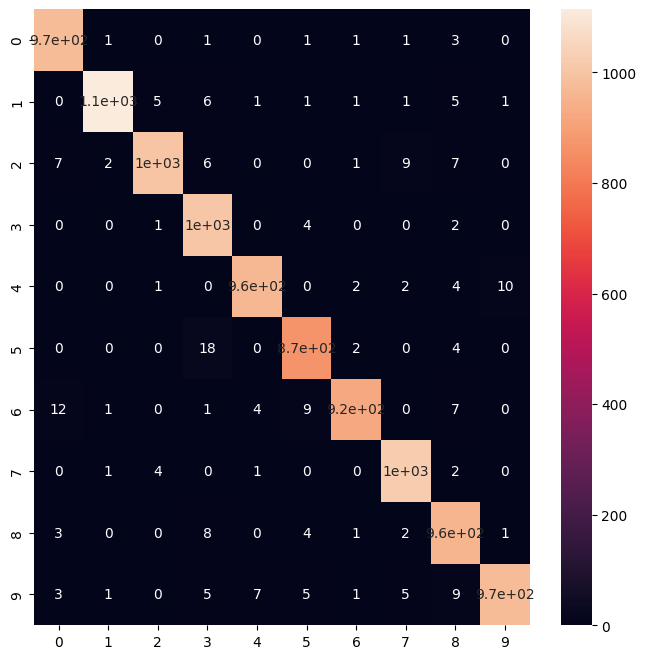

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions =  np.argmax(model.predict(x_test),axis=1)

cm = confusion_matrix(y_test,predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels = [0,1,2,3,4,5,6,7,8,9])

Vemos que nuestra red del primer apartado generaliza bastante bien. Esto nos hace tener una idea de cómo, en líneas generales el ***deep learning***, siempre y cuando dispongamos de las herramientas y recursos necesarias nos va a proporcinar mejores resultados, pues los procesos utilizados son mucho más complejos. Digamos que es la principal ventaja respecto al usar técnicas más clásicas.

\\
**RESUMEN**

 **1. Deep Learning, como su nombre indica, nos proporciona técnicas mucho más avanzadas y complejas que permiten llevar el entrenamiento de un modelo a otro nivel, así como su generalización.**

 **2. En general, la fase de *feature extraction* también la podemos obviar pues ya se encargar la propia red (feature learning). Los métodos más clásicos están demasiado expuestos a si se encuentra o no una buena representación de los datos y esto va a repercutir directamente en la calidad de las predicciones.**

 **3. La principal desventaja es la complejidad computacional que requieren las redes neuronales y cómo esto dificulta al *tuning* de sus parámetros.**

 **4. Los métodos más clásicos de aprendizaje automático nos pueden ofrecer buenos resultados y en tiempos más razonables. Sin embargo, la calidad de estos no siempre es óptima.**

## <font color='blue'> Apartado 3. Implementación y experimentación con uno o más modelos escogidos o diseñados por los estudiantes (2 puntos)

<font color='blue'> En este apartado, los alumnos deben diseñar su propia red neuronal para intentar mejorar los resultados obtenidos hasta el momento. Por ejemplo, se puede incrementar la profundidad de la red, el número o tamaño de los filtros convolucionales a aprender, se puede optar por emplear técnicas de regularización como Dropout o Batch Normalization, estrategias de _data augmentation_ o inicialización de pesos, etc. Queda a su elección la estrategia a seguir aunque, en cualquier caso, se valorará la complejidad de la propuesta realizada así como la calidad de la documentación aportada.

<font color='blue'> Del mismo modo, los estudiantes también pueden incluir una comparativa con el rendimiento de alguna otra técnica clásica de su elección (como Random Forest o Gradient Boosting) junto con vectores de características de su elección (incluyendo la modificación de los hiperparámetros del extractor de HOG usado en el apartado anterior, para lo cual será necesario que los alumnos revisen la documentación al respecto).

<font color='blue'> Dentro de este tercer apartado, en caso de que se haya saturado el rendimiento en MNIST (en el sentido de obtener una _accuracy_ en validación superior al $98\%$), se debe emplear como conjunto de datos $\textit{CIFAR-10}$ (https://archive.ics.uci.edu/dataset/691/cifar+10 y https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos contiene información sobre 10 clases de imágenes diferentes, y también está incluido directamente en Keras (https://keras.io/api/datasets/):

```
# Cargar el conjunto de datos CIFAR-10
cifar10 = tf.keras.datasets.cifar10

# Dividir los datos en entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Clases en CIFAR-10
class_names = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']
```

In [ ]:
# A CUBRIR POR EL ALUMNADO
# Cargar el conjunto de datos CIFAR-10
import tensorflow as tf

cifar10 = tf.keras.datasets.cifar10

# Dividir los datos en entrenamiento y prueba
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Clases en CIFAR-10
class_names = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Ciervo',
               'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

####**Red con mejoras**

Vamos a definir una nueva red convolucional, explicando ahora sólo los cambios que le vamos a hacer a la usada en el primer apartado:

\\
**DROPOUT**

**Dropout** es una técnica de regularización utilizada en redes neuronales para prevenir el sobreajuste durante el entrenamiento. Fue introducida por Srivastava et al. en 2014 y se ha convertido en una herramienta estándar en el diseño de redes neuronales profundas. Ver https://jmlr.org/papers/v15/srivastava14a.html

 Es una técnica en la que las neuronas seleccionadas al azar se ignoran durante el entrenamiento. **Se "descartan" aleatoriamente**. Esto significa que su contribución a la activación de las neuronas posteriores se elimina temporalmente en la pasada hacia adelante, y cualquier actualización de peso no se aplica a la neurona en la pasada hacia atrás (*backtracking*).

Algunas de las consideraciones que se dan en el *paper* son:
 1. Generalmente, usar un valor de dropout pequeño de entre 20%-50% de las neuronas, siendo 20% un buen punto de partida. Una probabilidad demasiado baja tiene un efecto mínimo, y un valor demasiado alto resulta en un aprendizaje insuficiente por parte de la red.

 2. Utilizar una red más grande. Es probable que se obtenga un mejor rendimiento cuando se usa Dropout en una red más grande, dando al modelo más oportunidades para aprender representaciones independientes.

 3. Usar Dropout en las unidades de entrada (visibles) así como en las unidades ocultas. La aplicación de Dropout en cada capa de la red ha mostrado buenos resultados.

<center><img src = 'https://www.baeldung.com/wp-content/uploads/sites/4/2020/05/2-1-2048x745-1.jpg'></center>

Imagen extraída de https://www.baeldung.com/cs/ml-relu-dropout-layers

\\
**BATCH NORMALIZATION**

**Batch Normalization** se refiere al proceso de normalizar las salidas de las neuronas en cada mini-lote (mini-batch) de datos. Esta normalización se realiza de forma que las activaciones tengan una media de cero y una desviación estándar de uno. Ver https://arxiv.org/abs/1502.03167

Esta técnica ayuda a **estabilizar y acelerar el proceso de entrenamiento** al mantener las activaciones en un rango más controlado, lo que permite utilizar tasas de aprendizaje más altas y no tener que preocuparnos de un *lr_scheduler* como hicimos antes. Tampoco es necesario preocuparse por la inicialización de los pesos.

También introduce un pequeño efecto de **regularización**, ya que el ruido en la estimación de la media y la desviación estándar durante el entrenamiento actúa como un regularizador.


En palabras de los autores, "*Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.*"

<center><img src = 'https://gradientscience.org/images/batchnorm/bn_schematic.jpg' ></center>

Imagen extraída de https://gradientscience.org/batchnorm/


Se puede colocar antes o después de la activación. La convención común es colocarlo antes de la activación (es decir, normalizar las activaciones lineales de la capa anterior antes de aplicarle la función de activación).

\\
**Definición de la red**

Ambas técnicas son **técnicas de regularización**, así como *earlyStopping*, usada anteriormente. Aunque como consecuencia de cada método conseguimos esta regularización, cada una desempeña un papel diferente en el entrenamiento. Es por eso, que vamos a fusionar ambas técnicas para crear la siguiente red:



In [ ]:
import keras
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation, Input

def definirRed2():
  model = keras.Sequential()
  model.add(Dropout(rate=0, input_shape=(32,32,3)))
  model.add(BatchNormalization())
  #Usamos dropout tanto en la entrada como en las capas ocultas

  model.add(Conv2D(128, (3,3), strides = 1 , padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Conv2D(64, (3,3), strides = 1 , padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (5,5), strides = 1 , padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(32, (5,5), strides = 1 , padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10))
  model.add(BatchNormalization())
  model.add(Activation('softmax'))

  model.summary()

  return model

model3 = definirRed2()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 32, 32, 3)         0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 3)         12        
 chNormalization)                                                
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)      

####**Entrenamiento**

Tras varias ejecuciones, encuentro siempre mejores resultados si no aplico *Dropout* a la capa de entrada. Yo esto lo interpreto como que al tener todos los ejemplos de entrenamiento activos, vamos a disponer de más información en el entrenamiento, aunque podamos perder la capacidad de aprender relaciones más independientes, digamos. Al final, **dejo a 0 el rate de *dropout* en la entrada**, me da mejores resultados. Para las ocultas, algunas a 0.2 (se apagan un 20%) de ellas y otras un 0.5 (un 50%).

El orden de las redes convolucionales se ha elegido así porque nuestro objetivo en una red neuronal en general es tratar de **aprender cada vez características de más alto nivel**. Por eso, las primeras capas usan filtros de 3x3 y cuando nos vamos adentrando en la red se usan de 5x5. También se ha usado más neuronas en las capas *fully conected* pues es uno de los consejos que se dan para el uso de dropout, el de aumentar el tamaño de la red. Veamos visualemente cómo queda la red:

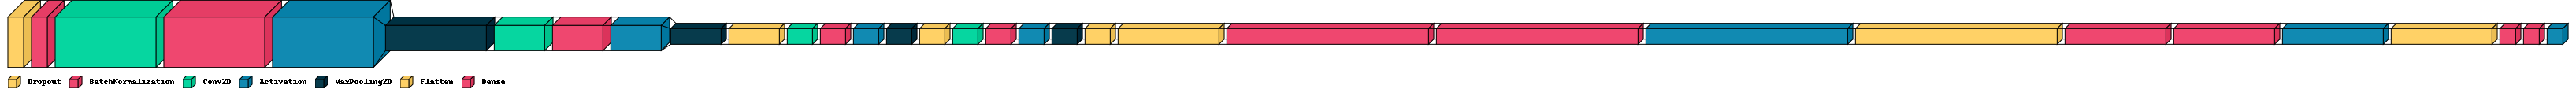

In [ ]:
#!pip install visualkeras
import visualkeras

visualkeras.layered_view(model3, legend = True, scale_xy=2, scale_z=1, max_z=1000)

Vamos a usar como *optimizer* ***SGD*** o ***Stocastic Gradient Descent***, para probar otro optimizador. De hecho, los dos mencionados en el apartado 1 están basados en este. Este es una variante del algoritmo de Gradient Descent (descenso de gradiente), y posee una **rápida convergencia** en general.

Para la función de pérdida es la misma que para el primer apartado. Compilemos nuestra red y veámos cómo se comporta en entrenamiento.

In [ ]:
from keras.optimizers import SGD

sgd = SGD(learning_rate=0.1, momentum=0.9)
loss=keras.losses.CategoricalCrossentropy()
model3.compile(loss=loss, optimizer=sgd, metrics=['accuracy'])
hist3 = model3.fit(x_train, y_train, batch_size = 64, epochs = 50, verbose=1, validation_split=0.2)

Epoch 1/50
625/625 [==============================] - 23s 18ms/step - loss: 1.7244 - accuracy: 0.3466 - val_loss: 1.5255 - val_accuracy: 0.4466
Epoch 2/50
625/625 [==============================] - 11s 17ms/step - loss: 1.3782 - accuracy: 0.5004 - val_loss: 1.2349 - val_accuracy: 0.5478
Epoch 3/50
625/625 [==============================] - 11s 17ms/step - loss: 1.2322 - accuracy: 0.5624 - val_loss: 1.0058 - val_accuracy: 0.6402
Epoch 4/50
625/625 [==============================] - 11s 18ms/step - loss: 1.1430 - accuracy: 0.5993 - val_loss: 1.0258 - val_accuracy: 0.6366
Epoch 5/50
625/625 [==============================] - 11s 17ms/step - loss: 1.0713 - accuracy: 0.6259 - val_loss: 0.8860 - val_accuracy: 0.6879
Epoch 6/50
625/625 [==============================] - 10s 17ms/step - loss: 1.0196 - accuracy: 0.6444 - val_loss: 0.9237 - val_accuracy: 0.6768
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.9766 - accuracy: 0.6659 - val_loss: 0.9438 - val_accuracy:

Obtenemos, **en validación, una accuracy del 80.44%**. Vemos que agota las 50 épocas, pues no hemos hecho ningún tipo de *EarlyStopping*. También el entrenamiento ha sido bastante gradual, para futuras ejecuciones podríamos variar el *learning rate* o probar con otro optimizador. Veámos ahora la evolución en entrenamiento del modelo:

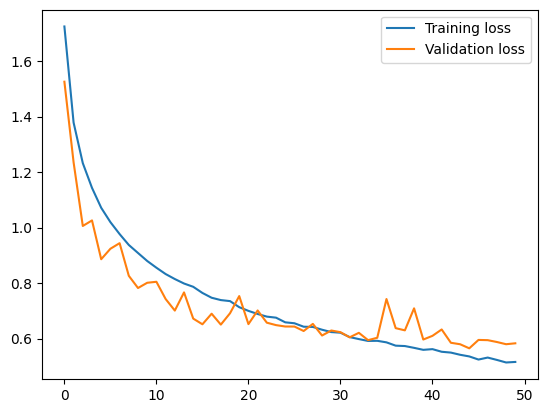

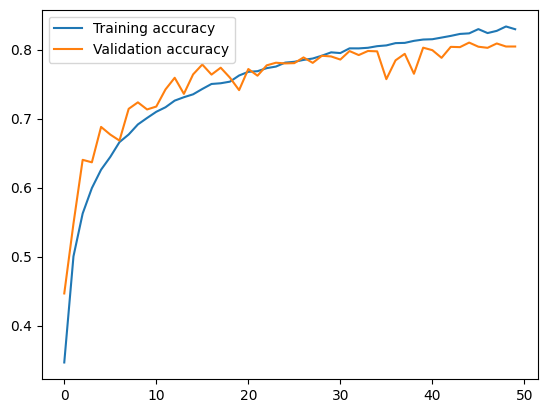

In [ ]:
mostrarEvolucion(hist3)

Vemos cómo siempre va bajando la *loss* en validación junto a la de *train*. Aunque no tiene por qué, esto podría indicarnos que igual aumentando el número de épocas conseguiríamos mejores resultados.

In [ ]:
calcularAccuracy(y_train, model3.predict(x_train))

1563/1563 [==============================] - 5s 3ms/step


0.89376

####**Comparación con HOG+RandomForest**

Antes de ir con los resultados, vamos a entrenar brevemente y sin hacer demasiado *tuning* un ***Random Forest*** usando las características HOG usadas en el apartado anterior. Para ello vamos a discutir también los parámetros del método:
 - **Orientations**: El número de orientaciones que se utilizarán al calcular los histogramas de gradientes. Cuantas más orientaciones se especifiquen, más sensible será el descriptor HOG a la dirección de los gradientes en la imagen. Se suele usar 6 o 12.
 - **pixels_per_cell**: El tamaño (en píxeles) de cada celda sobre la que se calculará el *histograma de gradientes*. Un valor más pequeño resultará en un mayor nivel de detalle en el descriptor HOG, pero también aumentará el costo computacional. Vamos a emplear (8,8) que también es comunmente usado.
 - **cells_per_block**: El número de celdas por bloque para normalizar los histogramas de gradientes. Normalizar los histogramas de gradientes en bloques ayuda a hacer el descriptor HOG más robusto a las variaciones locales en la iluminación y el contraste. Usaremos (2,2).

 Ver https://datasmarts.net/es/como-extraer-features-de-una-imagen-con-hog-en-scikit-image/


In [ ]:
from skimage.feature import hog

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

fd = hog(train_images[0], orientations=6, pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

x_train_HOG = np.zeros((train_images.shape[0],len(fd)), np.float32)
x_test_HOG = np.zeros((test_images.shape[0],len(fd)), np.float32)

for i in range(train_images.shape[0]):
  x_train_HOG[i] = hog(train_images[i], orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, channel_axis=-1)
for i in range(test_images.shape[0]):
  x_test_HOG[i] = hog(test_images[i], orientations=6, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, channel_axis=-1)

In [ ]:
print(x_train_HOG.shape)

(50000, 216)


También como hacíamos en el apartado 1.2, si queremos comparar dos modelos, **buscamos hacerlo de la manera más justa posible**, es decir, de nuevo usaremos para validar un conjunto con el 20% de los datos, pues es así como entrenamos a nuestra red.

In [ ]:
from sklearn.model_selection import train_test_split

x_train_HOG, x_val_HOG, train_labels, val_labels = train_test_split(x_train_HOG, train_labels, test_size=0.2, random_state=42)

print(x_train_HOG.shape)
print(x_val_HOG.shape)
print(train_labels.shape)
print(val_labels.shape)

(40000, 216)
(10000, 216)
(40000, 1)
(10000, 1)


**Random Forest** : Se construye un conjunto (ensemble) de árboles de decisión durante el entrenamiento. Cada árbol se entrena en un subconjunto aleatorio del conjunto de datos, y las características también se seleccionan aleatoriamente en cada división del árbol. (Ya explicado en la primera práctica, incluidos sus parámetros, no nos vamos a parar mucho)

Usaremos 40 árboles pues es un dataset considerable en tamaño, y un tamaño máximo de profundidad a 13.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators = 40, max_depth = 13)
clf.fit(x_train_HOG, train_labels)

<ipython-input-40-25244f7daa08>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train_HOG, train_labels)


RandomForestClassifier(max_depth=13, n_estimators=40)

In [ ]:
accuracy_score(train_labels, clf.predict(x_train_HOG))

0.912925

In [ ]:
accuracy_score(val_labels, clf.predict(x_val_HOG))

0.4879

####**Resultados**

Aunque muestre buenos resultados en *train*, es importante recalcar, que un modelo con RandomForest, está mucho más expuesto al problema del ***sobreajuste***, que también explicamos en la primera práctica (pues aprende rutas exactas dentro del árbol si le damos mucha profundidad y memoriza en lugar de aprender). De hecho esto es totalmente visible si analizamos en nuestro conjunto de validación, donde la accuracy baja hasta en 0.4 puntos, un verdadero desastre de modelo :)

Sin embargo, una red neuronal como la que hemos construido, siempre podemos tener claro que el proceso de **aprendizaje que haga va a ser mucho mejor**. Además, aunque una red sea un poco más "**caja negra**" y no sepamos exactamente qué está aprendiendo, incorporan muchas más técnicas de regularización, como ya hemos hecho en este apartado, mientras que en los métodos clásicos, la regularización depende únicamente de sus parámetros y el método. Es por esto que **nos quedamos con la red convolucional**. Veamos cómo generaliza:

In [ ]:
calcularAccuracy(y_test, model3.predict(x_test))

313/313 [==============================] - 1s 2ms/step


0.8007

Obtenemos un **89.37% de accuracy en train y un 80.07% en test**. Son resultados competentes pero no ideales, pues un 20% de las imágenes de test las predice mal. Como en todo problema de clasificación, usemos la matriz de confusión para ver cómo se ha realizado dicha clasificación, obteniendo:



313/313 [==============================] - 2s 6ms/step


<Axes: >

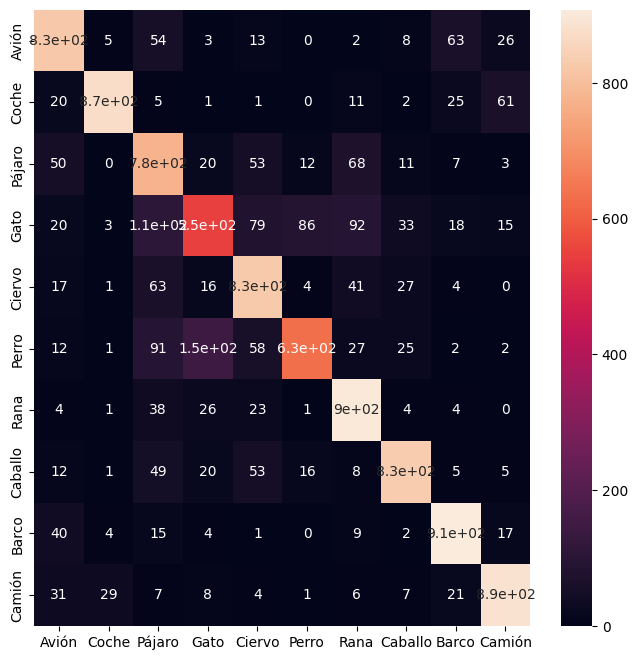

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model3.predict(x_test)
predictions_cm = predictions.argmax(1)

cm = confusion_matrix(test_labels,predictions_cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True,  xticklabels=class_names, yticklabels = class_names)

\\
Veámos ahora **cómo ha generalizado** nuestro modelo sacando las primeras 25 imágenes y viendo cuáles son sus verdaderas etiquetas y cuáles ha predicho nuestro modelo:

313/313 [==============================] - 1s 4ms/step


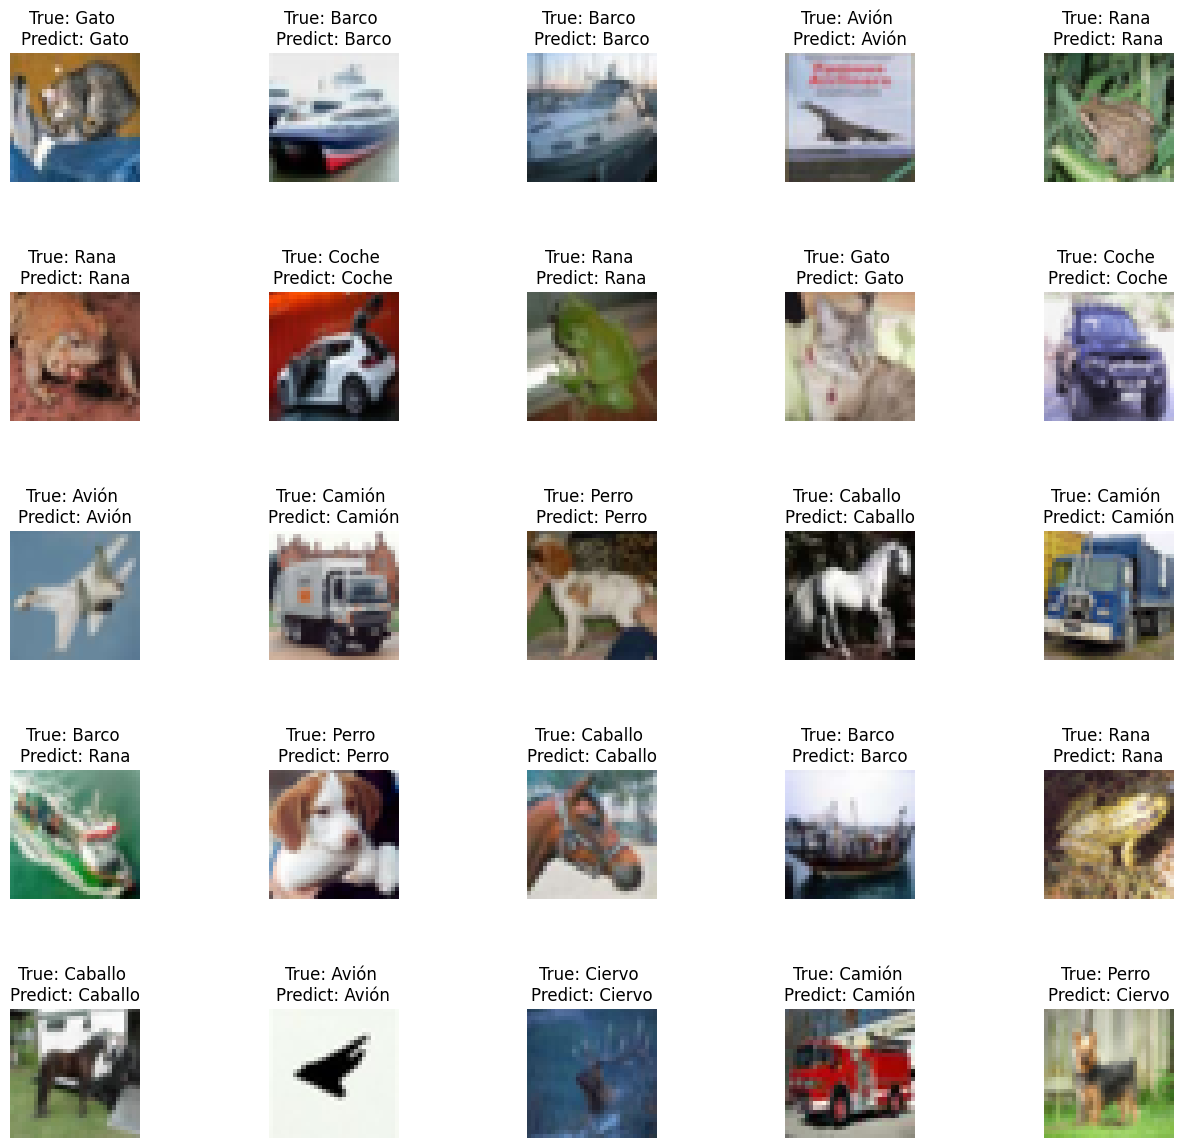

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

pred = model3.predict(x_test)
pred_classes = np.argmax(pred, axis=1)

for i in np.arange(0, 25):
    axes[i].imshow(x_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[np.argmax(y_test[i])], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

Hay ciertas instancias que no es capaz de predecir correctamente, véase:

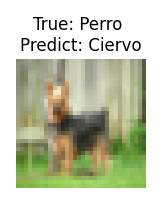

Sin embargo, considero que la red hace un buen trabajo, pues un 80% de ellas las clasifica correctamente. Sabiendo la complejidad del problema considero una buena solución la red dada, aunque todavía hay mucho margen de mejora.

\\
Mencionar por último que el dataset usado en este apartado, es ciertamente más complicado de manejar que el que usábamos en los dos anteriores. Cuenta con un  número de instancias similar pero **las características que se han de aprender son mucho más complicadas** y abstractas que las que pueda tener una imagen de un número en blanco y negro.

Aquí importa **la forma del objeto, los colores, el contorno...etc.**

También se podrían lanzar más experimentos, usando *data Augmentation*, por ejemplo.

# <font color='blue'>Ejercicio 2: PROBLEMA DE ELIMINACIÓN DE RUIDO EN IMÁGENES USANDO AUTOENCODERS (3 puntos) </font>

<font color='blue'> En este ejercicio los alumnos se enfrentarán al problema de eliminar ruido en imágenes. Para ello, se empleará el conjunto de datos $\textit{Fashion MNIST}$ (https://keras.io/api/datasets/fashion_mnist/), que contiene imágenes con 10 clases de ropa. En concreto, lo que haremos ahora es entrenar un modelo de aprendizaje automático conocido como autoencoder (que presenta una estructura _encoder-decoder_ y permite aprender representaciones (_embeddings_/_encodings_) altamente eficientes de forma no supervisada). Los autoencoders se emplean frecuentemente en tareas de reducción de dimensionalidad o detección de anomalías, y en este caso lo emplearemos para eliminar ruido en imágenes.

<font color='blue'> Referencias recomendadas sobre autoencoders:

*   <font color='blue'> Capítulo 14 de Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep learning. MIT press.
*   <font color='blue'> Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504-507.

<font color='blue'> Se parte de la implementación proporcionada en la propia documentación de Keras (cuya revisión detallada se recomienda a los estudiantes). https://keras.io/examples/vision/autoencoder/



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import fashion_mnist
from keras.models import Model


def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array,noise_factor):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


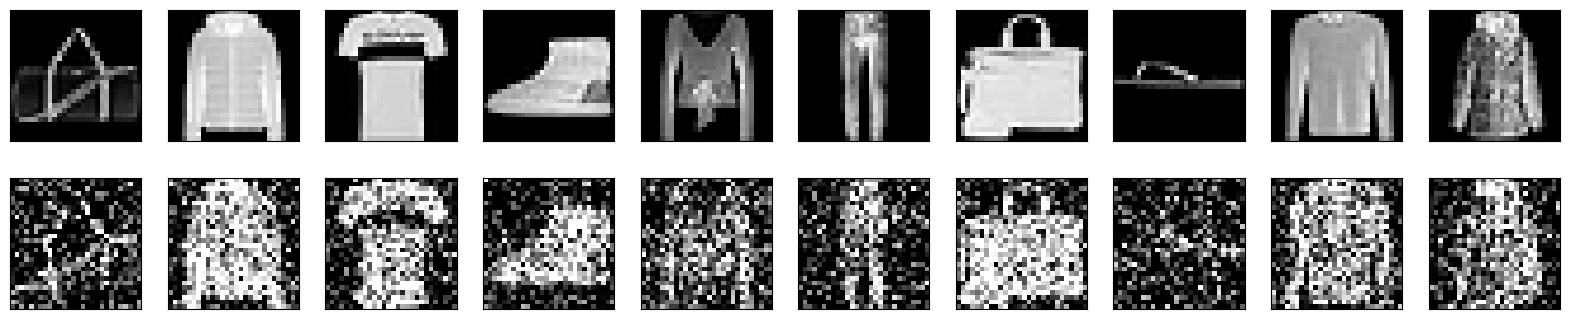

In [ ]:
(train_data, _), (test_data, _) = fashion_mnist.load_data()

train_data = preprocess(train_data)
test_data = preprocess(test_data)

noise_factor = 0.4

noisy_train_data = noise(train_data,noise_factor)
noisy_test_data = noise(test_data,noise_factor)

display(train_data, noisy_train_data)

<font color='blue'> Se debe construir un autoencoder en el que la parte _encoder_ debe contener tres bloques convolucionales como se indica a continuación:

1.   64 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada.
2.   32 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada. Este bloque convolucional va seguido por _max pooling_ de $2\times2$.
3.   16 filtros de convolución $3\times3$, función de activación _ReLU_, y volumen de salida del mismo tamaño que la entrada. Este bloque convolucional va seguido por _max pooling_ de $2\times2$.



<font color='blue'> A partir de esta información, los estudiantes deben construir la parte _decoder_ simétrica (mismo número de filtros y dimensiones) y responder las siguientes preguntas:

-  <font color='blue'> ¿Qué tipo de convolución se debe emplear en el _decoder_? ¿Basta con emplear una convolución convencional 2D? Se debe justificar y desarrollar la respuesta.
-  <font color='blue'> ¿Cuál es la función de activación y función de pérdida que se debe emplear a la salida? ¿Por qué?

-  <font color='blue'> Ahora, a la hora de entrenar nuestro autoencoder, ¿cuáles serían las entradas ($X$) y salidas ($y$)? Y en relación con este punto, ¿por qué mencionábamos que los autoencoders son técnicas no supervisadas? ¿Cuáles son las etiquetas anotadas que empleamos?

Hablemos en primer lugar de los **autoencoders**: Son un tipo de red neuronal (en nuestro caso va a ser convolucional también) que consta de una estructura de *encoder - decoder*. Veámos esto:
 - **Encoder**: Esta parte de la red toma la entrada y la convierte en una representación de menor dimensión. Se puede representar como
 $h = f(x)$, donde $x$ es la entrada y $h$ es la representación codificada.

 - **Decoder**: Esta parte toma el código de baja dimensión y trata de reconstruir la entrada original a partir de él. Se puede representar como $x' = g(h) = g(f(x))$, donde $g$ representa la función decodificadora o de reconstrucción de la entrada.

 <center><img src = 'https://th.bing.com/th/id/OIP.QEmCZtruuWwtEOUzew2D4AHaFj?rs=1&pid=ImgDetMain'></center>

 Imagen extraída de https://velog.io/@yimethan/Autoencoder

El autoencoder se entrena de manera que **la salida reconstruida sea lo más cercana posible a la entrada original**.

Los autoencoders tienen diversos usos en el *deep learning*, como reducción de dimensionalidad (similar a PCA pero no es lineal), detección de anomalías,...etc

Nosotros vamos a crear un autoencoder que nos permita reconstruir nuestras imágenes de partida pero habiendo introducido cierto ruido previamente. Es decir, los vamos a emplear en una tarea de ***denoising*** o eliminación de ruido. Nuestro objetivo va a ser reconstruir imágenes con ruido tratando que sean lo más fiel a la realidad pero eliminando ese ruido.

\\
**APRENDIZAJE NO SUPERVISADO**

El **caracter no supervisado** de este entrenamiento viene dado por la siguiente explicación: cuando trabajamos con autoencoders, **su entrenamiento no requiere etiquetas externas o clases para los datos**. En lugar de eso, el autoencoder se entrena utilizando solamente las entradas, buscando reconstruirlas de la manera más precisa posible. En nuestro caso, como entrada le damos las imágenes con ruido y queremos que como salida tengamos las imágenes sin ruido. De esta manera, en el entrenamiento el autoencoder sabrá si estamos haciendo una reconstrucción correcta o no. Todo esto se resume en el párrafo siguiente:

**No hay etiquetas adicionales o valores objetivos que el modelo necesite predecir. El único objetivo es minimizar la diferencia entre la entrada y su reconstrucción.**

\\
**FUNCIÓN DE ACTIVACIÓN Y PÉRDIDA**

En cuanto a la función de pérdida que se ha de usar se trata de ***Binary Cross Entropy***, la cual se utiliza principalmente para tareas de clasificación binaria, donde el objetivo es clasificar las entradas en una de dos clases.

  - Penaliza fuertemente los errores en las predicciones de los píxeles, especialmente cuando los valores predichos están lejos de los valores reales. Esto ayuda a que el autoencoder aprenda a reconstruir las imágenes de manera más precisa.

**Realmente lo que queremos ver es si la imagen de salida ha sido reconstruida correctamente y es similar a la de entrada, es decir, se aproxima a un problema de clasificación binaria.**

Siguiendo con esta línea de clasificación binaria, de igual manera, usaremos como función de activación para la capa de salida la ***función sigmoide***.

  - La función de activación sigmoide convierte los valores de las salidas en un rango $[0, 1]$. Esto es útil porque permite que la red neuronal produzca salidas que pueden interpretarse como probabilidades.

<center><img src = 'https://i.stack.imgur.com/KcX81.png' ></center>

Imagen extraída de https://imathworks.com/math/math-sigmoid-circ-sigmoid-sigmoid/

La *BinaryCrossEntropy* se combina bien con la función de activación *sigmoide*. La primera mide la distancia entre la probabilidad predicha por la segunda y la probabilidad real, proporcionando una pérdida que refleja adecuadamente la calidad de la reconstrucción.

\\
 Para ello, tanto la entrada como la salida han de tener **misma dimensión**. Se discute debajo de la declaración de la red la construcción de las convoluciones simétricas. Adelantamos que no van a ser las mismas que *Conv2D*.

####**Definición del autoencoder**

In [ ]:
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose

def definirAutoEncoder():
  #encoder
  model = Sequential()
  model.add(Input(shape = (28,28, 1)))
  model.add(Conv2D(64, (3,3), strides = 1 , padding = 'same', activation = 'relu'))
  model.add(Conv2D(32, (3,3), strides = 1 , padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Conv2D(16, (3,3), strides = 1 , padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  #decoder
  model.add(Conv2DTranspose(16, (3,3), strides = 2, padding = 'same', activation = 'relu'))
  model.add(Conv2DTranspose(32, (3,3), strides = 2, padding = 'same', activation = 'relu'))
  model.add(Conv2DTranspose(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

  model.summary()

  return model

autoEncoder1 = definirAutoEncoder()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 16)       

La última capa del *decoder* realmente nos da igual cuál sea, siempre y cuando se use la función sigmoide como activación y no cambiemos la dimensionalidad, pues debe coincidir con la de la entrada. Igualmente lo más común es usar una capa convolucional, nosotros hemos puesto un solo filtro $3$x$3$.

Las convoluciones usadas son las ***Convoluciones Traspuestas***: son una operación utilizada en redes neuronales convolucionales para realizar el **proceso inverso de una convolución estándar**. Mientras que las convoluciones normales reducen el tamaño espacial de una imagen, las convoluciones traspuestas aumentan la dimensión de la imagen.

Si lo que queremos hacer es lo contrario a la convolución, hemos de partir de una matriz más pequeña $2$x$2$, por ejemplo, y multiplicar cada uno de los pesos de la misma por el filtro $3$x$3$, por ejemplo, obteniendo así 4 matrices $3$x$3$. Luego se pueden combinar las 4 para formar una nueva matriz $4$x$4$, por ejemplo. Un ejemplo visual:

<img src = 'https://miro.medium.com/v2/resize:fit:720/format:webp/1*eeMbMohZF-K3OsAlbiJBZA.png'>

Imagen extraída de https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967

Un **proceso equivalente** sería el de usar convoluciones normales para el decoder, solo que en este caso tendríamos que usar **UpSamplig**, que consiste en aumentar la dimensionalidad de la imagen usando distintas técnicas. La diferencia entre ambos métodos recae en que cuando se aprenden primero unos pesos sin aumentar la dimensionalidad y luego se hace upsampling de manera manual, **estamos aprendiendo esos coeficientes *end-to-end***, mientras que haciendo convoluciones traspuestas, se aprenden dichos coeficientes e inmediatamente se sube de dimensionalidad.

\\
Una vez tenemos nuestro *autoEncoder* definido, veámos visualmente sus capas y pasemos a la fase de entrenamiento:

In [ ]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.8 MB/s eta 0:00:00


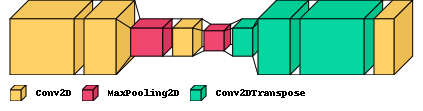

In [ ]:
visualkeras.layered_view(autoEncoder1, legend = True, scale_xy=2, scale_z=1, max_z=1000)

<font color='blue'> Ahora se debe entrenar el autoencoder empleando _early stopping_, y el número de épocas, tamaño de batch y demás hiperparámetros que se consideren adecuados (justificando siempre, eso sí, las decisiones tomadas: como es habitual, bien sea basándose en la literatura científica y documentación existentes o bien en la experimentación y evidencia empírica a nuestra disposición). En un primer momento, entrenamos con las imágenes sin ruido, para verificar que somos capaces de reconstruir adecuadamente las imágenes originales de entrada. Como conjunto de validación, en este ejercicio, podemos emplear los datos de test.

Ahora vamos con la prueba de verdad. Vamos a ver si realmente nuestro autoencoder funciona como debería, pues sin ruido alguno **debería ser capaz de reconstruir las imágenes de entrada** sin demasiado problema. Para ello, vamos a usar la misma estrategia de entrenamiento que usábamos en el primer ejercicio:

 - **Exponential Decay, optimizador AdamW, earlyStopping**
 - **Para el *batch_size* vamos a usar uno más grande, pues ahora los tiempos de entrenamiento son mayores.**
 - **Usamos *train_data* como input pues son las imágenes del conjunto de entrenamiento y las mismas imágenes como salida a esperar. Como conjunto de validación, tal y como se nos indica vamos a usar el conjunto de test. Esto realmente lo hacemos pues nuestro trabajo ahora es el de *denoising*. Realmente no nos importa cómo se comporte en test y cuantos más ejemplos tengamos para nuestro entrenamiento y validación mejor.**

####**Primer entrenamiento (reconstrucción sin ruido)**

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
import keras

callback = EarlyStopping(monitor='val_loss', patience = 4)

loss=keras.losses.BinaryCrossentropy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

optimizer = tf.keras.optimizers.AdamW( learning_rate = lr_schedule )


autoEncoder1.compile(optimizer = optimizer, loss = loss, metrics=['mse'])
hist = autoEncoder1.fit(train_data, train_data, batch_size = 64, epochs = 50, verbose=1, validation_data=(test_data, test_data), callbacks=[callback])

Epoch 1/50
938/938 [==============================] - 18s 11ms/step - loss: 0.2754 - mse: 0.0115 - val_loss: 0.2628 - val_mse: 0.0065
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - loss: 0.2590 - mse: 0.0060 - val_loss: 0.2593 - val_mse: 0.0054
Epoch 3/50
938/938 [==============================] - 11s 12ms/step - loss: 0.2571 - mse: 0.0054 - val_loss: 0.2589 - val_mse: 0.0053
Epoch 4/50
938/938 [==============================] - 11s 11ms/step - loss: 0.2558 - mse: 0.0050 - val_loss: 0.2576 - val_mse: 0.0049
Epoch 5/50
938/938 [==============================] - 12s 13ms/step - loss: 0.2550 - mse: 0.0047 - val_loss: 0.2591 - val_mse: 0.0055
Epoch 6/50
938/938 [==============================] - 14s 15ms/step - loss: 0.2541 - mse: 0.0044 - val_loss: 0.2556 - val_mse: 0.0042
Epoch 7/50
938/938 [==============================] - 10s 11ms/step - loss: 0.2533 - mse: 0.0041 - val_loss: 0.2549 - val_mse: 0.0040
Epoch 8/50
938/938 [==============================] - 10s 11ms

**Tras varias ejecuciones, me doy cuenta de que en el contexto de autoencoders, la métrica de accuracy no es la más adecuada para evaluar el rendimiento del modelo. Un autoencoder está diseñado para aprender una codificación de los datos de entrada y luego reconstruir los datos desde esta representación. La accuracy generalmente se refiere a la proporción de predicciones correctas en tareas de clasificación, lo cual no se aplica directamente a los autoencoders, ya que su objetivo principal no es clasificar, sino reconstruir los datos de entrada.**

Es por esto que para este problema en concreto vamos a usar la **métrica MSE**, pues la considero más adecuada para este escenario. Nos servirá para tener una idea de la precisión global del modelo en términos de diferencias pixel a pixel. Vemos que el error es muy bajo para este entrenamiento, al menos en validación y esto nos indica que al menos en teoría, se ha hecho una buena recosntrucción.

Ahora cambiemos la función *mostrarEvolucion*, pues queremos que muestre en lugar de la accuracy el mse:



In [ ]:
def mostrarEvolucion2(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['mse']
    val_acc = hist.history['val_mse']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training mse','Validation mse'])
    plt.show()


Sin embargo, llegados a este punto es mucho mejor ver visualmente cómo ha reconstruido nuestro encoder las imágenes de entrada. Veámos varios ejemplos:

313/313 [==============================] - 1s 2ms/step


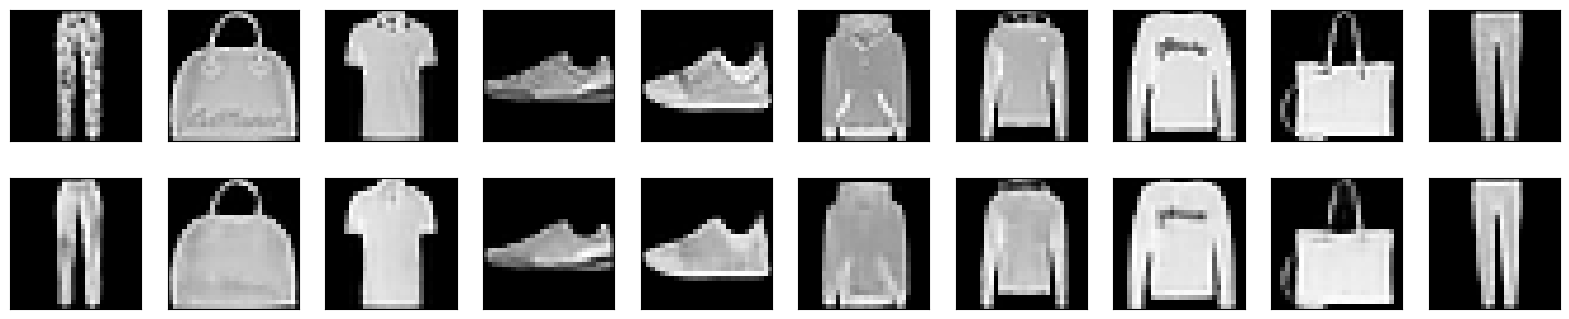

In [ ]:
display(test_data, autoEncoder1.predict(test_data))

Salvo algunos pixeles en concreto, vemos que es capaz de ***entender*** o ***aprender*** las formas, los contornos y la ropa en general y es capaz de reconstruirla. Aquí es bastante visible cómo funcionan las redes neuronales, pues en todas las instancias es capaz de retener cuáles son las características a más alto nivel. Veámos cómo se ha desarrollado también el entrenamiento, a modo informativo:

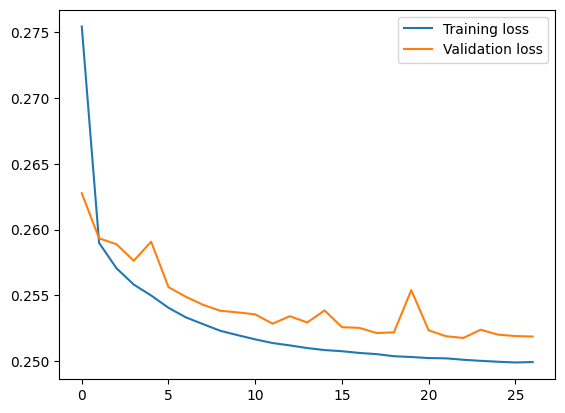

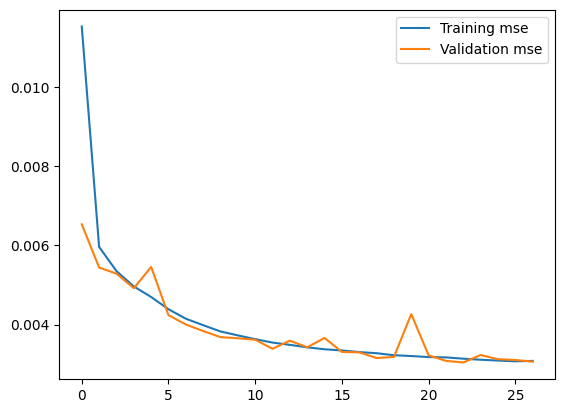

In [ ]:
mostrarEvolucion2(hist)

<font color='blue'> Ahora vamos a entrenar con las imágenes ruidosas a la entrada y las imágenes sin ruido a la salida. Nuestro propósito es crear un modelo que permita reconstruir a la salida las imágenes sin ruido. Se deben discutir los resultados obtenidos, así como si se percibe alguna diferencia entre las curvas de entrenamiento cuando se emplean imágenes con y sin ruido.

Volvemos a crear un autoEncoder, pues no podemos usar el mismo, **Keras guarda el estado del entrenamiento de todos sus modelos**.

In [ ]:
#creamos otro autoencoder
autoEncoder2 = definirAutoEncoder()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 16)       

####**Segundo entrenamiento (reconstrucción con ruido)**

De igual manera, vamos a usar el mismo procedimiento de entrenamiento que hacíamos antes con las imágenes sin ruido. La diferencia ahora es que **corrompemos las imágenes de entrada**, de manera que tengan cierto factor de ruido en sus píxeles (en este caso 0.4). De esta manera, ahora el objetivo del encoder es tratar de reconstruir la imagen original, es decir, eliminar el ruido que nosotros hemos introducido.

 - Para entrenar vamos a usar como entrada *noisy_train_data* y como salida los datos sin ruido *train_data*. De igual forma para validación usaremos *noisy_test_data* y *test_data*.

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience = 4)

loss=keras.losses.BinaryCrossentropy()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

optimizer = tf.keras.optimizers.AdamW(learning_rate = lr_schedule)

autoEncoder2.compile(optimizer = optimizer, loss = loss, metrics=['mse'])
hist2 = autoEncoder2.fit(noisy_train_data, train_data, batch_size = 64, epochs = 50, verbose=1, validation_data=(noisy_test_data, test_data), callbacks=[callback])

Epoch 1/50
938/938 [==============================] - 17s 14ms/step - loss: 0.3049 - mse: 0.0199 - val_loss: 0.2924 - val_mse: 0.0149
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - loss: 0.2879 - mse: 0.0141 - val_loss: 0.2897 - val_mse: 0.0141
Epoch 3/50
938/938 [==============================] - 11s 12ms/step - loss: 0.2859 - mse: 0.0135 - val_loss: 0.2871 - val_mse: 0.0133
Epoch 4/50
938/938 [==============================] - 11s 12ms/step - loss: 0.2850 - mse: 0.0132 - val_loss: 0.2874 - val_mse: 0.0133
Epoch 5/50
938/938 [==============================] - 9s 10ms/step - loss: 0.2845 - mse: 0.0131 - val_loss: 0.2885 - val_mse: 0.0137
Epoch 6/50
938/938 [==============================] - 10s 10ms/step - loss: 0.2841 - mse: 0.0129 - val_loss: 0.2864 - val_mse: 0.0130
Epoch 7/50
938/938 [==============================] - 10s 10ms/step - loss: 0.2838 - mse: 0.0129 - val_loss: 0.2870 - val_mse: 0.0132
Epoch 8/50
938/938 [==============================] - 10s 10ms/

Ahora el mse también es muy bajo, esto nos indica que a bajo nivel, hemos sido capaces de reconstruir exitosamente las imágenes. Aun así, considero que lo mejor es ver visualmente para este caso cómo se ha comportado el autoEncoder a más alto nivel:

313/313 [==============================] - 1s 2ms/step


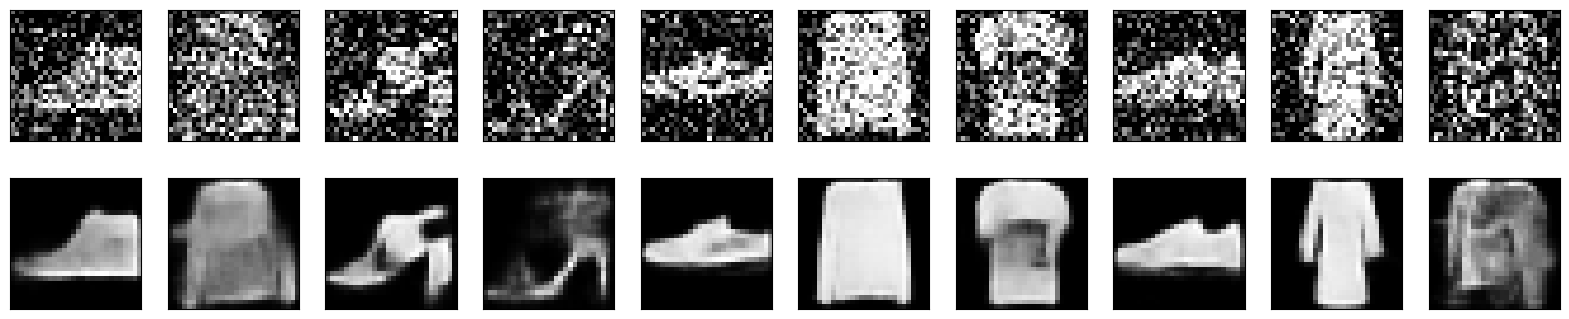

In [ ]:
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))

Aparentemente es capaz de eliminar el ruido y quedarse con **la idea de la prenda**. Es decir, aunque tenga muchos píxeles de ruido, es capaz de clasificar la primera imagen como un zapato. O para la sexta imagen, clasificarla como una camiseta.

**Reminder 1**: Cuando aquí uso la palabra "clasificar", me estoy refiriendo a que la red lo reconstruye como tal, porque realmente no estamos en una tarea de clasificación, si no que estamos ante un problema de aprendizaje no supervisado.

**Reminder 2**: Podemos usar directamente el conjunto de test porque en este caso concreto estamos tratándolo como si fuese el conjunto de validación, pues nuestro verdadero objetivo es el *denoising*.

\\
Visualicemos ahora también la evolución del entrenamiento, por si nos pudiese dar más información:

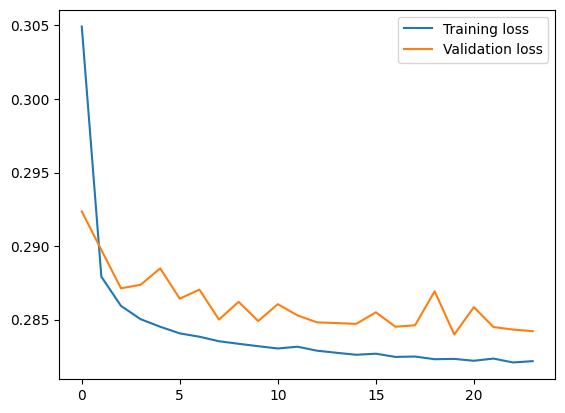

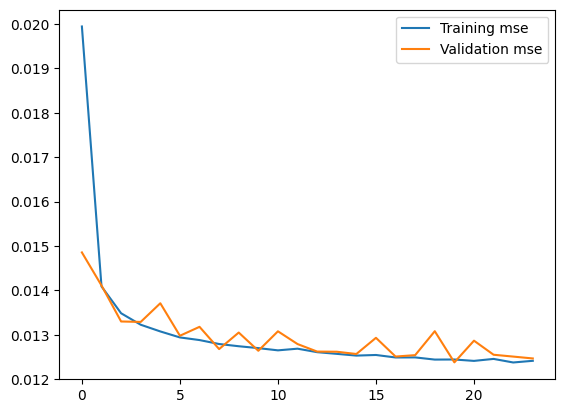

In [ ]:
mostrarEvolucion2(hist2)

Cabe mencionar en cuanto a las gráficas anteriores que el mse tanto en *train* como en *test* "converge" rápidamente a un mismo valor y luego le cuesta mucho al modelo corregirlo. De hecho, al usar *earlyStopping* el entrenamiento termina muy rápido. Esto se debe a lo mencionado antes; si calculamos el mse para estas imágenes, se nos devuelve un array donde dicha mse es calculada pixel a pixel. **Ser preciso pixel a pixel en una tarea donde además las imágenes de entrada tienen ruido, hace que las características a bajo nivel en nuestro autoencoder pierdan mucha importancia y la red se centre en las de más alto nivel.** Por esto no se ve mejora visual conforme avanza el entrenamiento.

<font color='blue'> Finalmente, se deben realizar dos experimentos.  

1.   Por un lado, probar con distintos `noise_factor` progresivamente más severos de ruido, para comprobar si hay algún límite (_breakpoint_) a partir del cual la reconstrucción de las imágenes ruidosas se resiente. En otras palabras, queremos estudiar hasta qué grado de ruidosidad podemos reconstruir nuestras imágenes contaminadas con ruido.
2.   Por otro lado, debemos investigar si el autoencoder entrenado generaliza y permite reconstruir imágenes en presencia de ruido diferente. Sin realizar ningún otro entrenamiento, y empleando el autoencoder ya entrenado, ¿podemos reconstruir las imágenes contaminadas con este otro tipo de ruido? Para simular dicho ruido se debe emplear la función que se proporciona más abajo (`noise2()`), aunque se da libertad al alumnado para experimentar también con otros tipos de ruido. ¿Qué conclusiones se pueden extraer de este experimento?



In [ ]:
def noise2(image, noise_factor):
    noisy_array = image.copy()
    probs = np.random.random(noisy_array.shape[:2])
    noisy_array[probs < noise_factor/2] = 0.0
    noisy_array[probs > 1 - (noise_factor/2)] = 1.0
    return np.clip(noisy_array, 0.0, 1.0)

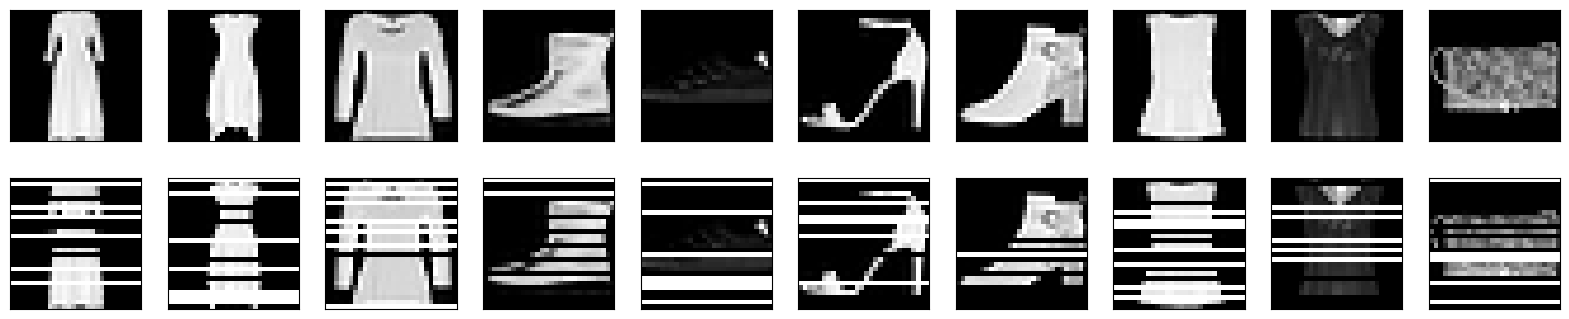

In [ ]:
noise_factor = 0.4

noisy_test_data = noise2(test_data,noise_factor)

display(test_data, noisy_test_data)

Vamos ahora a crear una función que nos calcule manualmente el MSE de las predicciones hechas por los modelos:

In [ ]:
def calcularMSE(labels, preds):
    mse = np.average((labels - preds)**2)
    return mse

Este de arriba es un nuevo tipo de ruido que introducimos a las imágenes. La idea de este apartado en concreto es que nos demos cuenta de cómo el **tipo de ruido** influye en el entrenamiento y posterior inferencia del modelo, así como, consecuentemente en su rendimiento.

Es por esto que no vamos a entrenar ni redefinir ninguno de los autoencoders, si no que vamos a usar los que ya tenemos entrenados (en mi caso *autoEncoder2*) para hacer *predict()* sobre nuevos datos o imágenes que vamos a ir creando con las funciones dadas al principio del enunciado, para ver si el modelo es capaz de eliminar el ruido que se le pasa.

\\
Vamos a **ir incrementando en 0.1 el factor de ruido para el primer tipo de ruido (gaussiano)** definido al principio del ejercicio. Veámos cómo reconstruye nuestro autoEncoder:

####**Experimentando con mismo ruido**

Ruido tipo 1 de 0.5

313/313 [==============================] - 1s 2ms/step


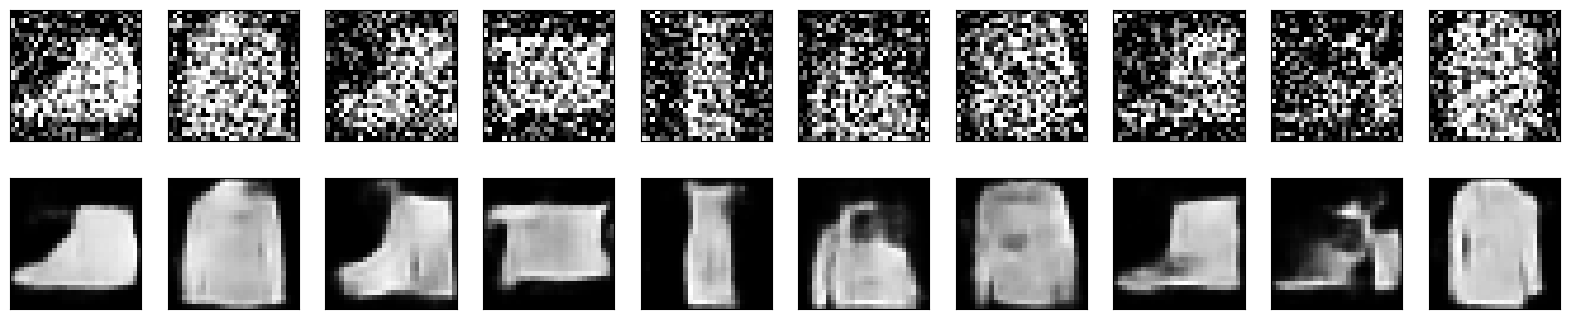

313/313 [==============================] - 1s 2ms/step
Ruido tipo 1 de 0.6

313/313 [==============================] - 1s 2ms/step


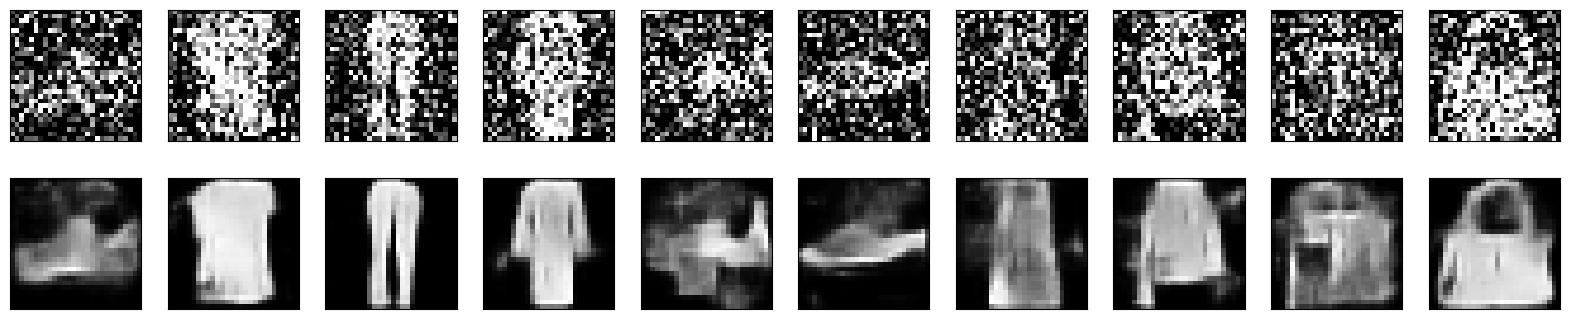

313/313 [==============================] - 1s 2ms/step
Ruido tipo 1 de 0.7

313/313 [==============================] - 1s 2ms/step


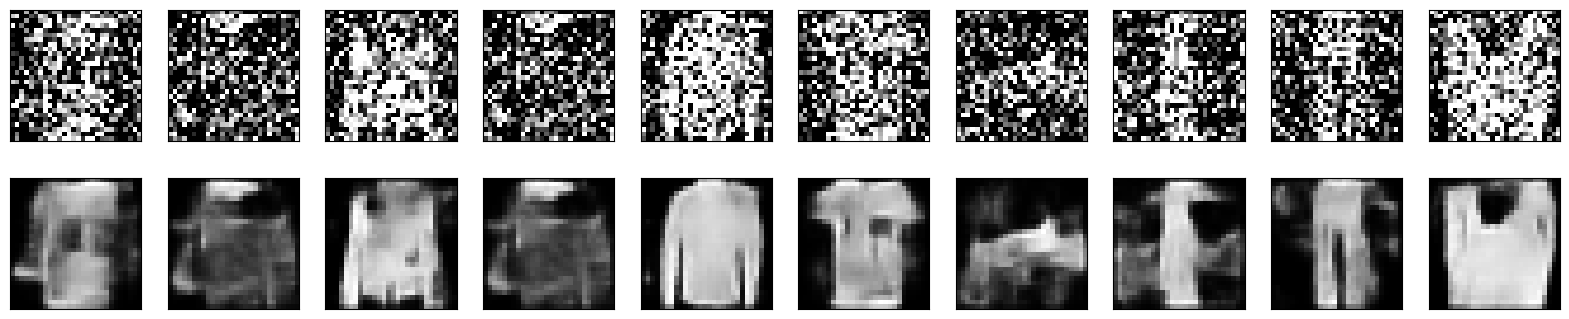

313/313 [==============================] - 1s 3ms/step
Ruido tipo 1 de 0.8

313/313 [==============================] - 1s 3ms/step


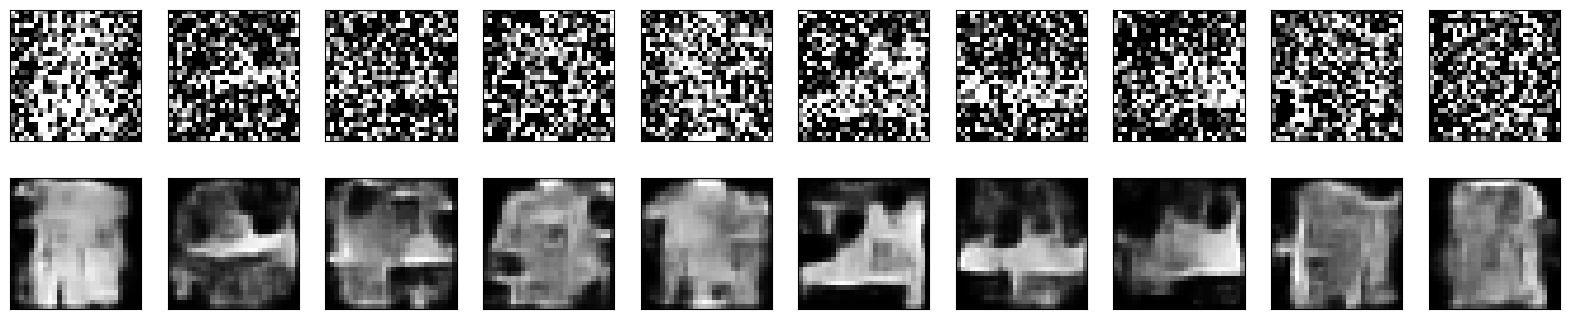

313/313 [==============================] - 1s 2ms/step
Ruido tipo 1 de 0.9

313/313 [==============================] - 1s 2ms/step


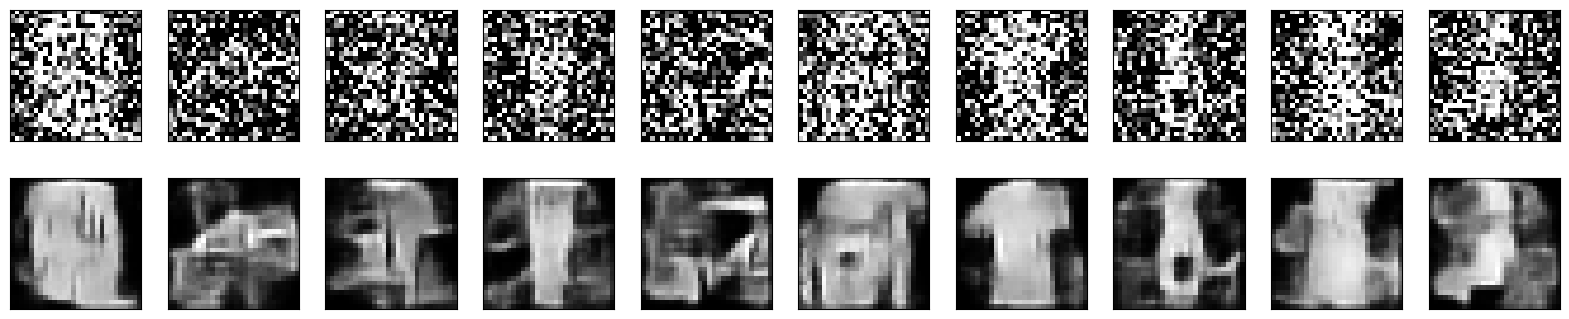

313/313 [==============================] - 1s 4ms/step


In [ ]:
#Vamos primero noise (el primero de los ruidos definido)
from sklearn.metrics import mean_squared_error

noisy_test_data = noise(test_data,0.5)
print("Ruido tipo 1 de 0.5")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse1 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise(test_data,0.6)
print("Ruido tipo 1 de 0.6")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse2 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise(test_data,0.7)
print("Ruido tipo 1 de 0.7")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse3 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise(test_data,0.8)
print("Ruido tipo 1 de 0.8")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse4 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise(test_data,0.9)
print("Ruido tipo 1 de 0.9")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse5 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

In [ ]:
print(mse1, mse2, mse3, mse4, mse5)

0.016878458 0.024187755 0.03358559 0.04343463 0.052761767


Al menos visualmente, parece que a partir $noiseFactor = 0.7$ o $noiseFactor = 0.8$ nuestro modelo tiene más dificultades para reconstruir las imágenes. Pero **esto no implica un mal funcionamiento**, pues en estos casos son factores tan altos que estamos casi eliminando la imagen original, haciendo la reconstrucción casi imposible a ojos de un ser humano. Apoyémonos de la siguiente gráfica, donde se muestra cómo vamos perdiendo *accuracy* conforme añadimos más y más ruido:

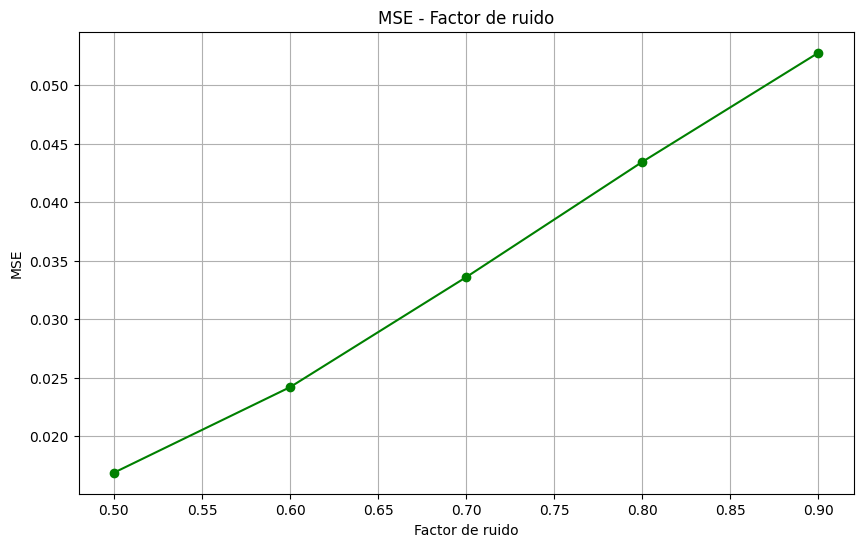

In [ ]:
noise_factors = [0.5, 0.6, 0.7, 0.8, 0.9]

mse = [mse1, mse2, mse3, mse4, mse5]

plt.figure(figsize=(10, 6))
plt.plot(noise_factors, mse, marker='o', linestyle='-', color='g')
plt.title('MSE - Factor de ruido')
plt.xlabel('Factor de ruido')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Como cabía esperar al introducir gradualmente más y más ruido los resultados son de peor calidad pues el autoEncoder no es capaz de predecir bien la imagen de entrada, es casi irreconocible cuando nos acercamos a valores altos de ruido.

**Realmente, aunque nos salgan mse's bajos, las predicciones se van haciendo peores y peores. De hecho, es importante recalcar, que para este experimento estamos usando un encoder que ha sido entrenado con imágenes con 0.4 de factor de ruido. Le estamos exigiendo que prediga con mucho más ruido y esto evidentemente nos hace tener peores resultados. Si entrenáramos el mismo modelo pero con datos con mismo ruido que las imágenes a predecir, obtendríamos mejores resultados. Aún así, cabría esperar que cuanto más ruido más difícil de predecir.**

Es por esto, que como no se nos dice que no podamos entrenar para este experimento, vamos a entrenar uno con un **nivel de ruido de 0.8**, para ver cómo predice imágenes con el mismo tipo de ruido, y comparar con el resultado anterior:

#####**Experimento entrenando otro autoEncoder**


In [ ]:
autoEncoder3 = definirAutoEncoder()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 16)       

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience = 4)

loss=keras.losses.BinaryCrossentropy()

#Ponemos factor de ruido a 0.8
noisy_train_data = noise(train_data, 0.8)
noisy_test_data = noise(test_data, 0.8)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)

optimizer = tf.keras.optimizers.AdamW(learning_rate = lr_schedule)

autoEncoder3.compile(optimizer = optimizer, loss = loss, metrics=['mse'])
hist3 = autoEncoder3.fit(noisy_train_data, train_data, batch_size = 64, epochs = 50, verbose=1, validation_data=(noisy_test_data, test_data), callbacks=[callback])

Epoch 1/50
938/938 [==============================] - 16s 14ms/step - loss: 0.3541 - mse: 0.0355 - val_loss: 0.3418 - val_mse: 0.0309
Epoch 2/50
938/938 [==============================] - 10s 10ms/step - loss: 0.3348 - mse: 0.0289 - val_loss: 0.3347 - val_mse: 0.0283
Epoch 3/50
938/938 [==============================] - 10s 11ms/step - loss: 0.3320 - mse: 0.0280 - val_loss: 0.3338 - val_mse: 0.0279
Epoch 4/50
938/938 [==============================] - 10s 11ms/step - loss: 0.3311 - mse: 0.0278 - val_loss: 0.3325 - val_mse: 0.0277
Epoch 5/50
938/938 [==============================] - 13s 14ms/step - loss: 0.3299 - mse: 0.0274 - val_loss: 0.3321 - val_mse: 0.0275
Epoch 6/50
938/938 [==============================] - 10s 11ms/step - loss: 0.3292 - mse: 0.0271 - val_loss: 0.3309 - val_mse: 0.0272
Epoch 7/50
938/938 [==============================] - 10s 11ms/step - loss: 0.3289 - mse: 0.0271 - val_loss: 0.3308 - val_mse: 0.0271
Epoch 8/50
938/938 [==============================] - 11s 11ms

Ruido tipo 1 de 0.8 predicho por un autoencoder entrenado para 0.8

313/313 [==============================] - 1s 2ms/step


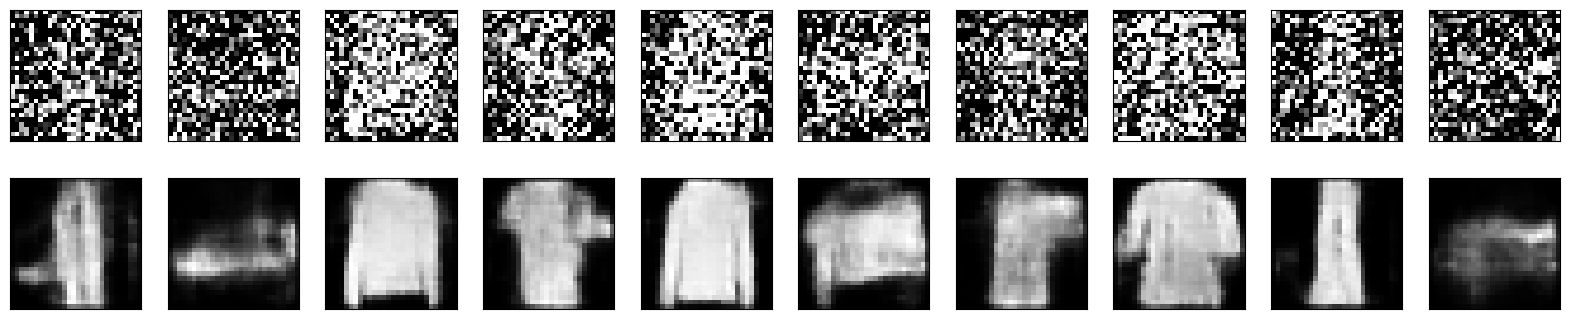

313/313 [==============================] - 1s 2ms/step
MSE:  0.030023493


In [ ]:
print("Ruido tipo 1 de 0.8 predicho por un autoencoder entrenado para 0.8")
print("")
display(noisy_test_data, autoEncoder3.predict(noisy_test_data))
mse = calcularMSE(test_data, autoEncoder3.predict(noisy_test_data))
print("MSE: ", mse)

**Comparemos con el entrenado para 0.4:**

Ruido tipo 1 de 0.8 predicho por un autoencoder entrenado para 0.4
313/313 [==============================] - 1s 3ms/step


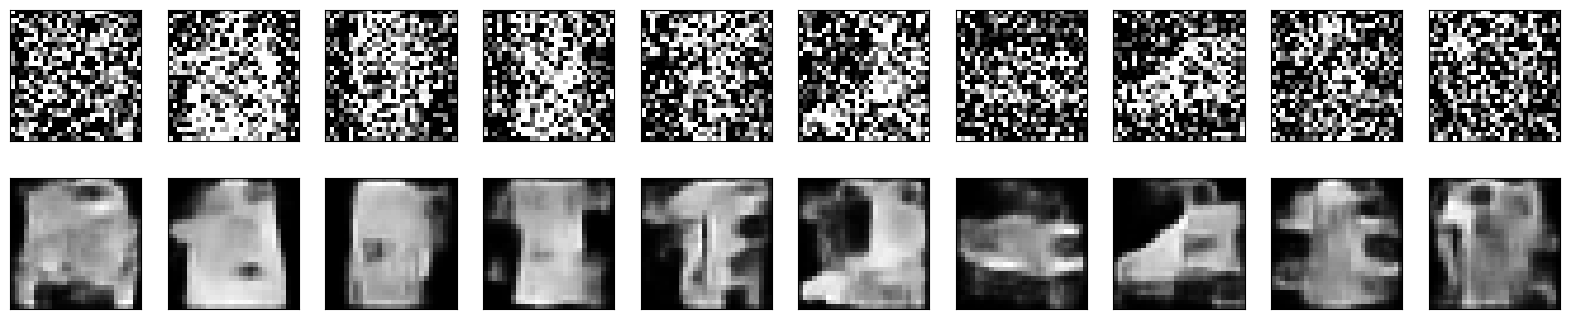

313/313 [==============================] - 1s 2ms/step
MSE:  0.043444235


In [ ]:
noisy_test_data = noise(test_data,0.8)
print("Ruido tipo 1 de 0.8 predicho por un autoencoder entrenado para 0.4")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))
print("MSE: ", mse)

Tanto visualmente como en mse, vemos que hay mejora de un modelo a otro. **Este experimento confirma todo lo explicado anteriormente.**

####**Experimentando con otro tipo de ruido**

Ahora vamos a usar la función dada que como se ve al principio del ejercicio, introduce un ruido de barras horizontales a las imágenes, totalmente distinto del primer ruido que usábamos en el ejercicio. Vamos a ver cómo se comporta nuestro modelo autoencoder para este caso también, incrementando cada vez más el factor de ruido para ver cómo escala con este factor el rendimiento:

Ruido tipo 2 de 0.5

313/313 [==============================] - 1s 2ms/step


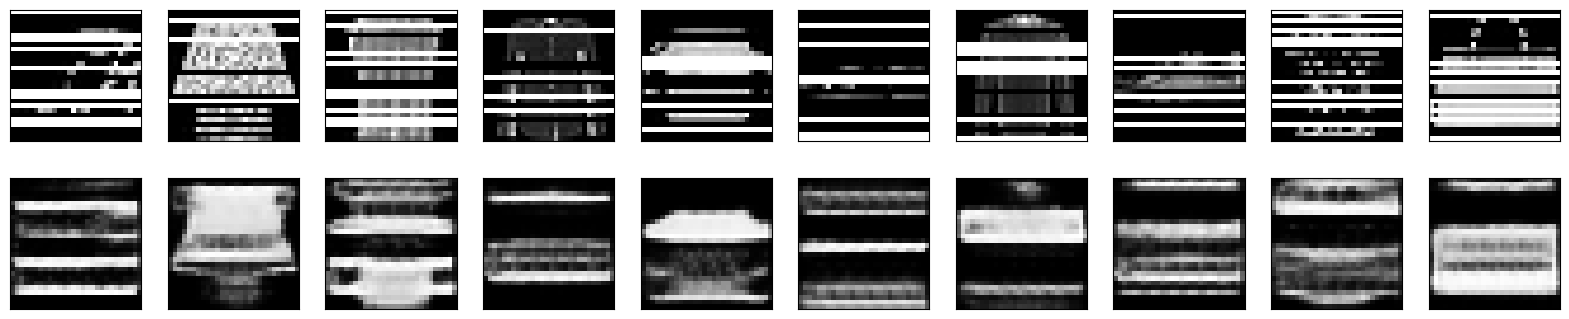

313/313 [==============================] - 1s 2ms/step
Ruido tipo 2 de 0.6

313/313 [==============================] - 1s 2ms/step


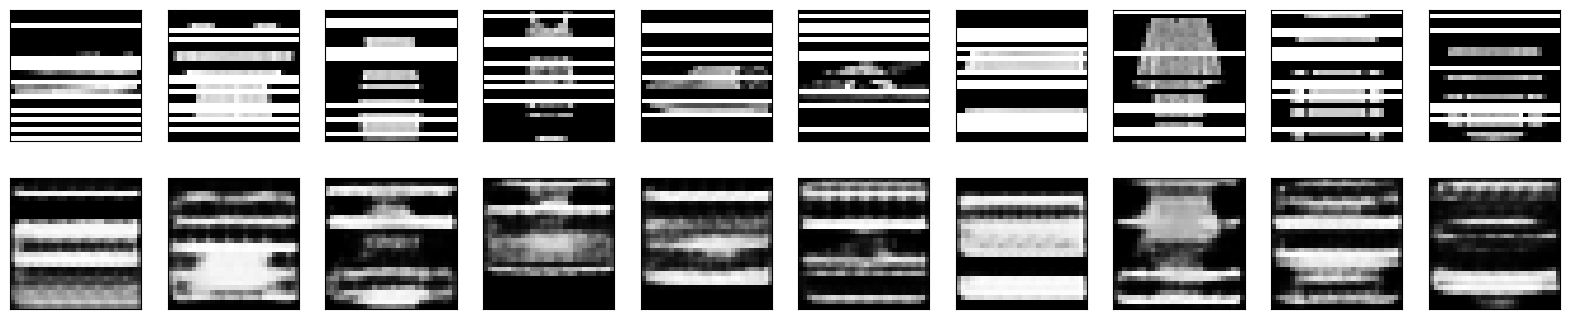

313/313 [==============================] - 1s 2ms/step
Ruido tipo 2 de 0.7

313/313 [==============================] - 1s 3ms/step


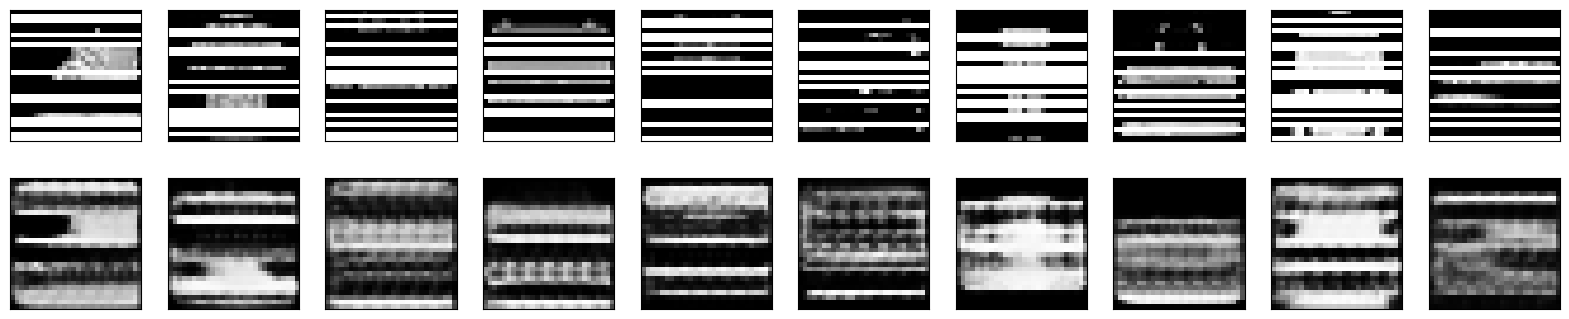

313/313 [==============================] - 1s 3ms/step
Ruido tipo 2 de 0.8

313/313 [==============================] - 1s 3ms/step


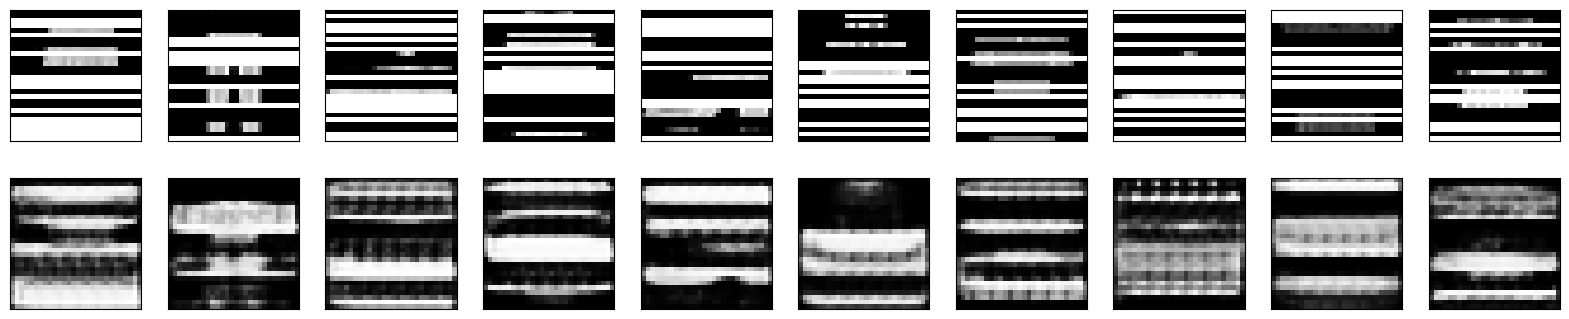

313/313 [==============================] - 1s 5ms/step
Ruido tipo 2 de 0.9

313/313 [==============================] - 1s 3ms/step


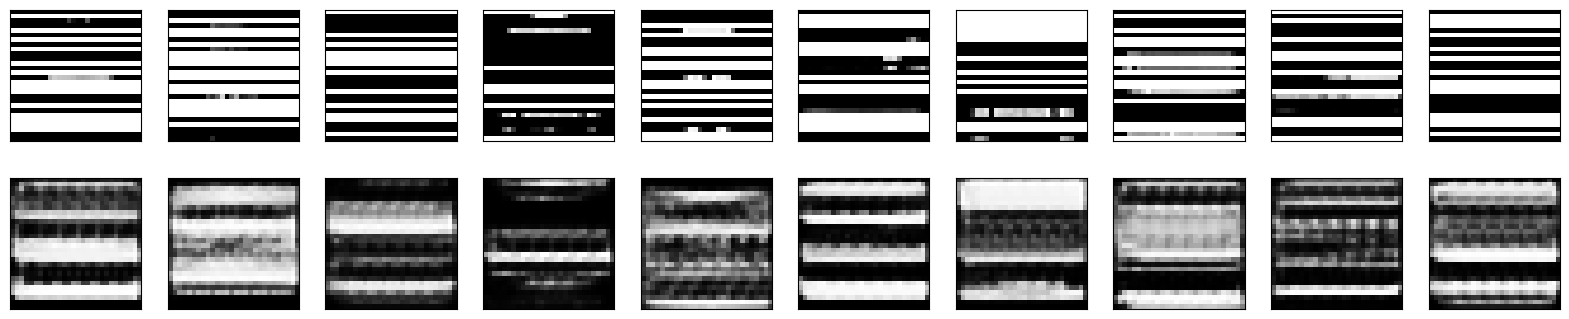

313/313 [==============================] - 1s 2ms/step


In [ ]:
#Vamos ahora con noise2
noisy_test_data = noise2(test_data,0.5)
print("Ruido tipo 2 de 0.5")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse1 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise2(test_data,0.6)
print("Ruido tipo 2 de 0.6")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse2 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise2(test_data,0.7)
print("Ruido tipo 2 de 0.7")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse3 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise2(test_data,0.8)
print("Ruido tipo 2 de 0.8")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse4 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

noisy_test_data = noise2(test_data,0.9)
print("Ruido tipo 2 de 0.9")
print("")
display(noisy_test_data, autoEncoder2.predict(noisy_test_data))
mse5 = calcularMSE(test_data, autoEncoder2.predict(noisy_test_data))

In [ ]:
print(mse1, mse2, mse3, mse4, mse5)

0.14006573 0.16460548 0.18810531 0.21059364 0.23096824


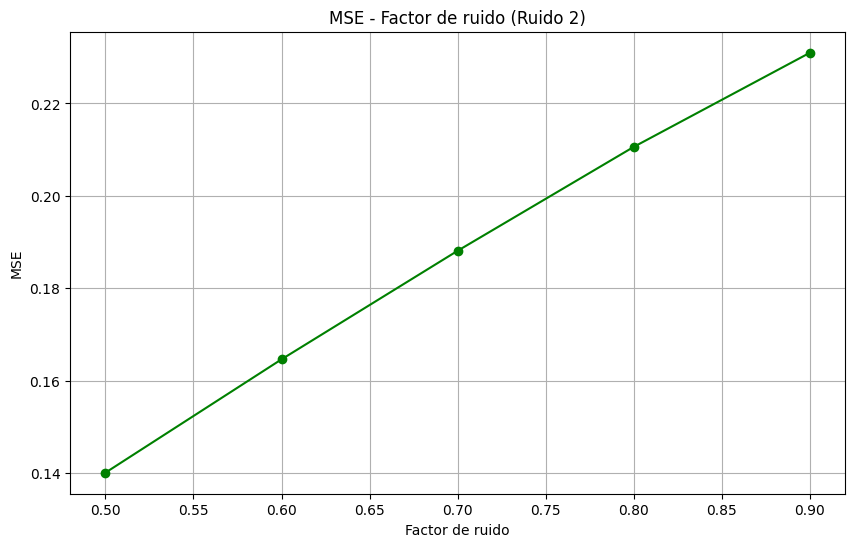

In [ ]:
noise_factors = [0.5, 0.6, 0.7, 0.8, 0.9]

mse = [mse1, mse2, mse3, mse4, mse5]

plt.figure(figsize=(10, 6))
plt.plot(noise_factors, mse, marker='o', linestyle='-', color='g')
plt.title('MSE - Factor de ruido (Ruido 2)')
plt.xlabel('Factor de ruido')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

De igual manera que ocurría para el primer tipo de ruido, ahora conforme vamos añadiendo más y más ruido del segundo tipo, vamos obteniendo un mse cada vez más alto, y con **valores mucho más altos que para el primer ruido**.

La principal diferencia entre ambas predicciones para los dos tipos de ruido es que:
 1. Ya visualmente vemos que incluso para 0.5 de noise_factor pero del tipo de ruido 2, la reconstrucción se aleja considerablemente de la realidad de la imagen.
 2. En las gráficas mostradas esto también se ve para el primer ruido vs el segundo, pues en general el mse es bastante menor.

Podemos entonces afirmar los siguiente: **El rendimiento de un autoencoder entrenado para denoising con un tipo específico de ruido se degrada cuando se enfrenta a un tipo diferente de ruido.**

El autoencoder ha aprendido a identificar y eliminar específicamente el ruido gaussiano. Si se le presentan imágenes con un tipo diferente de ruido, es probable, y es lo que pasa en nuestro caso, que no funcione tan bien porque no ha sido entrenado para reconocer y eliminar ese tipo de ruido.

Algunas posibles soluciones a este problema del ruido podrían ser:
 - Entrenar el autoencoder con una combinación de diferentes tipos de ruido para ayudar al modelo a generalizar mejor y manejar diversos tipos de ruido. (como hemos hecho antes para ruido1 con 0.8)
 - Utilizar un ensamblaje de varios autoencoders, cada uno entrenado con un tipo específico de ruido, y seleccionar el mejor modelo para cada tipo de ruido durante la inferencia.